# Sample-Specific Variance in Differential Analysis

This tutorial demonstrates how to perform differential analysis in single-cell data while accounting for biological variance between samples. We'll explore:

1. Why sample variance matters in differential analysis
2. How to run Kompot analyses with and without sample variance
3. How to visualize and interpret the results
4. How sample variance affects statistical significance

## Introduction to Sample Variance

When analyzing single-cell data across multiple samples (e.g., different patients, mice, or experimental batches), it's crucial to account for sample-specific effects. The variability between samples can often be much larger than the variability between conditions, leading to inflated significance estimates if not properly accounted for.

Kompot provides built-in support for sample variance estimation, which:

- Trains estimators for each sample separately
- Computes variance across samples within each condition
- Adjusts statistical significance estimates based on sample variability
- Provides more conservative and robust differential results

## Setup and Data Loading

First, let's load the necessary libraries and set up our environment:

In [2]:
import anndata as ad
import matplotlib.pyplot as plt

# Import necessary libraries
import numpy as np
import palantir
import pandas as pd
import scanpy as sc
import seaborn as sns

import kompot

# Set plotting style
sc.settings.set_figure_params(dpi=150, figsize=[5, 5])
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["image.cmap"] = "Spectral_r"

/Users/dotto/micromamba/envs/kompot_v1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now let's define the parameters for our analysis. In this tutorial we're using a bone marrow dataset with cells from young and old individuals. We'll compare these two conditions while accounting for biological variation across individual samples.

In [3]:
# Data path - replace with your own AnnData file path
# For reproducibility, you can download the example file from:
# https://zenodo.org/records/10153433
DATA_PATH = "../data/processed_filtered_HSPCandMature_withcorrection_withregression_postcelltype.h5ad"

# Analysis parameters
SAMPLE_COLUMN = "Replicate"  # Column in adata.obs with sample labels
GROUPING_COLUMN = "Age"  # Column in adata.obs with condition labels
CONDITIONS = ["Young", "Old"]  # Conditions to compare (first is reference)
CELL_TYPE_COLUMN = "highres_celltype"  # Column in adata.obs with cell type annotations
DIMENSIONALITY_REDUCTION = (
    "DM_EigenVectors"  # Key in adata.obsm for cell state representation
)
LAYER_FOR_EXPRESSION = (
    "logged_counts"  # Layer in adata.layers for expression data (None uses adata.X)
)

In [4]:
adata = ad.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 8090 × 16285
    obs: 'Compartment', 'Replicate', 'Age', 'Sample', 'Info', 'batch', 'doublet_score', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'S_score', 'G2M_score', 'phase', 'leiden', 'phenograph', 'highres_celltype', 'midres_celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Age_colors', 'Compartment_colors', 'DMEigenValues', 'Info_colors', 'README', 'Replicate_colors', 'Sample_colors', 'batch_colors', 'draw_graph', 'highres_celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'midres_celltype_colors', 'neighbors', 'pca', 'phase_colors', 'umap'
    obsm: 'AbCapture', 'DM_EigenVectors', 'HTO', 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'X_pca_noregression',

## Exploring the Data

Before running any analysis, it's important to understand the structure of your data. Let's visualize the data to understand:

1. **Cell Type Distribution**: How many cells of each type are in our dataset?
2. **Condition Distribution**: How balanced are our conditions (Young vs. Old)?
3. **Cell Type by Condition**: Are certain cell types biased toward particular conditions?

These exploratory analyses will help us interpret the differential results later.

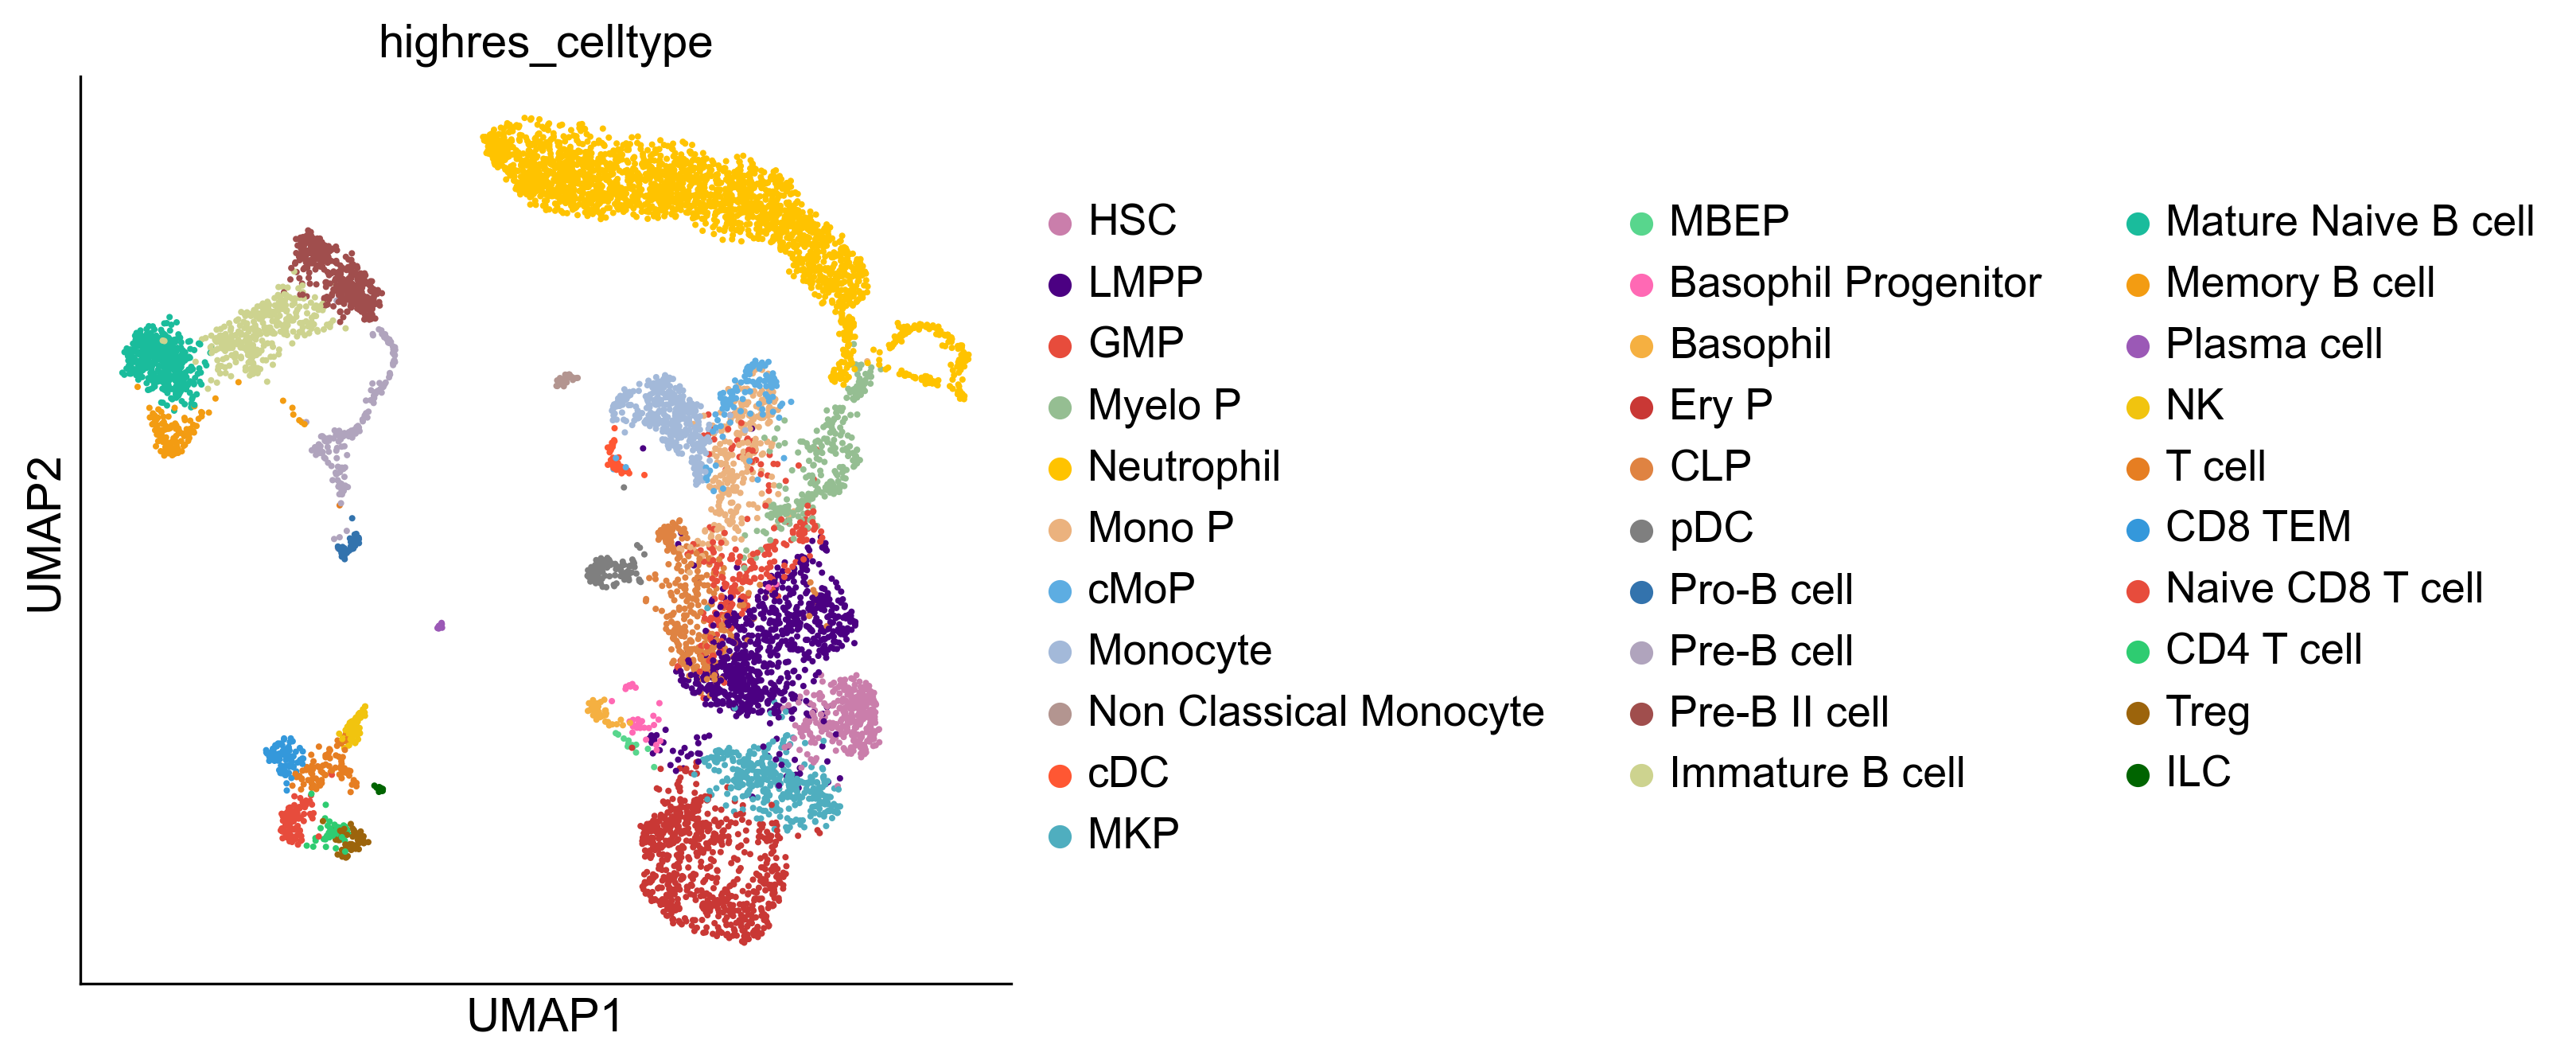

In [5]:
sc.pl.umap(adata, color=CELL_TYPE_COLUMN)

In [5]:
palantir.utils.run_diffusion_maps(adata, pca_key="X_pca_harmony", n_components=40);

## Standard Differential Analysis (Without Sample Variance)

First, we'll demonstrate the standard differential analysis approach that doesn't account for sample-specific variance. This is the typical approach used when either there's only one sample per condition, or when you're intentionally ignoring sample-specific effects.

### Step 1: Differential Abundance Analysis

We'll start by computing differential abundance between young and old conditions. This analyzes changes in the cell state distribution without considering sample-specific effects:

In [6]:
# First, let's compute differential abundance between conditions
da_results = kompot.compute_differential_abundance(
    adata,  # AnnData object
    groupby=GROUPING_COLUMN,  # Column with condition labels
    condition1=CONDITIONS[0],  # Reference condition
    condition2=CONDITIONS[1],  # Comparison condition
    obsm_key=DIMENSIONALITY_REDUCTION,  # Cell state representation
)

[2025-03-12 15:52:12,999] [INFO    ] Condition 1 (Young): 2,917 cells
[2025-03-12 15:52:13,001] [INFO    ] Condition 2 (Old): 3,116 cells
[2025-03-12 15:52:13,011] [INFO    ] Fitting density estimator for condition 1...
[2025-03-12 15:52:23,446] [INFO    ] Fitting density estimator for condition 2...


### Step 2: Differential Expression Analysis

Next, we'll compute differential expression between the conditions using the same approach without sample variance. This identifies genes that change between conditions:

In [7]:
# Now, compute differential expression between the conditions
de_results = kompot.compute_differential_expression(
    adata,  # AnnData object
    groupby=GROUPING_COLUMN,  # Column with condition labels
    condition1=CONDITIONS[0],  # Reference condition
    condition2=CONDITIONS[1],  # Comparison condition
    layer=LAYER_FOR_EXPRESSION,  # Expression data layer
    obsm_key=DIMENSIONALITY_REDUCTION,  # Cell state representation
    differential_abundance_key="kompot_da",  # DA results for weighted log-fold change (optional)
    batch_size=0,  # set to, e.g., 100 to batch cells and genes for lower memory demand
)

[2025-03-12 15:52:30,952] [INFO    ] Condition 1 (Young): 2,917 cells
[2025-03-12 15:52:30,953] [INFO    ] Condition 2 (Old): 3,116 cells
[2025-03-12 15:52:32,713] [INFO    ] Fitting expression estimator for condition 1...
[2025-03-12 15:52:38,824] [INFO    ] Fitting expression estimator for condition 2...
[2025-03-12 15:52:44,859] [INFO    ] Landmark storage skipped (store_landmarks=False). Compute with store_landmarks=True to enable landmark reuse.
[2025-03-12 15:52:57,563] [INFO    ] Computing Mahalanobis distances...
[2025-03-12 15:52:57,564] [INFO    ] Using landmarks from function_predictor1 with shape (5000, 40)
[2025-03-12 15:52:57,564] [INFO    ] Using 5,000 landmarks for Mahalanobis computation
[2025-03-12 15:53:04,937] [INFO    ] Computing Mahalanobis distances for 16,285 genes with shared covariance...
[2025-03-12 15:53:05,145] [INFO    ] Computing Cholesky decomposition for covariance matrix
[2025-03-12 15:53:06,463] [INFO    ] Successfully computed Mahalanobis distances f

## Differential Analysis With Sample Variance

Now, we'll perform the same analyses while accounting for sample-specific variance. The key difference is including the `sample_col` parameter, which tells Kompot which column in `adata.obs` contains the sample identifiers.

### Step 1: Differential Abundance with Sample Variance

The first step is similar, but now we include the sample information:

In [8]:
# First, let's compute differential abundance between conditions
da_results = kompot.compute_differential_abundance(
    adata,  # AnnData object
    groupby=GROUPING_COLUMN,  # Column with condition labels
    condition1=CONDITIONS[0],  # Reference condition
    condition2=CONDITIONS[1],  # Comparison condition
    obsm_key=DIMENSIONALITY_REDUCTION,  # Cell state representation
    sample_col=SAMPLE_COLUMN,  # Sample labels
)

[2025-03-12 15:53:06,916] [INFO    ] Results with result_key='kompot_da' already exist in the dataset. Previous run was at 2025-03-12T15:52:30.933601 comparing Young vs Old. Fields that will be overwritten: obs:kompot_da_log_fold_change_Young_vs_Old, obs:kompot_da_log_density_Young. Note: Only fields NOT affected by sample variance (like log_fold_change, log_density) will be overwritten since they don't use the sample variance suffix. These results will likely be identical if other parameters haven't changed. This is a partial rerun with sample variance added to a previous analysis with matching parameters. Set overwrite=False to prevent overwriting or overwrite=True to silence this message.
[2025-03-12 15:53:06,918] [INFO    ] Condition 1 (Young): 2,917 cells
[2025-03-12 15:53:06,919] [INFO    ] Condition 2 (Old): 3,116 cells
[2025-03-12 15:53:06,922] [INFO    ] Using sample column 'Replicate' for sample variance estimation
[2025-03-12 15:53:06,923] [INFO    ] Found 3 unique sample(s)

### Step 2: Differential Expression with Sample Variance

For differential expression analysis with sample variance, memory usage can be much higher because Kompot computes a gene-specific covariance matrix for each gene. To manage memory usage, we'll analyze only the top 100 genes (by Mahalanobis distance) from our previous analysis.

In [9]:
# Now, compute differential expression between the conditions
topn = 100
de_results = kompot.compute_differential_expression(
    adata,  # AnnData object
    groupby=GROUPING_COLUMN,  # Column with condition labels
    condition1=CONDITIONS[0],  # Reference condition
    condition2=CONDITIONS[1],  # Comparison condition
    layer=LAYER_FOR_EXPRESSION,  # Expression data layer
    obsm_key=DIMENSIONALITY_REDUCTION,  # Cell state representation
    differential_abundance_key="kompot_da",  # DA results for weighted log-fold change (optional)
    batch_size=0,  # set to, e.g., 100 to batch cells and genes for lower memory demand
    sample_col=SAMPLE_COLUMN,  # Sample labels
    genes=adata.var.sort_values("kompot_de_mahalanobis_Young_vs_Old", ascending=False)
    .head(topn)
    .index,
)

[2025-03-12 15:53:35,988] [INFO    ] Differential expression results with result_key='kompot_de' already exist in the dataset. Previous run was at 2025-03-12T15:53:06.891213 comparing Young vs Old. Fields that will be overwritten: var:kompot_de_mean_lfc_Young_vs_Old, var:kompot_de_bidirectionality_Young_vs_Old, layers:kompot_de_imputed_Young, layers:kompot_de_fold_change_Young_vs_Old. Note: Only fields NOT affected by sample variance (like mean_log_fold_change, bidirectionality, imputed data, fold_change) will be overwritten since they don't use the sample variance suffix. These results will likely be identical if other parameters haven't changed. This is a partial rerun with sample variance added to a previous analysis with matching parameters. Set overwrite=False to prevent overwriting or overwrite=True to silence this message.
[2025-03-12 15:53:35,989] [INFO    ] Condition 1 (Young): 2,917 cells
[2025-03-12 15:53:35,990] [INFO    ] Condition 2 (Old): 3,116 cells
[2025-03-12 15:53:36

Computing gene-specific Mahalanobis distances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.05it/s]


[2025-03-12 15:56:42,689] [INFO    ] Successfully computed Mahalanobis distances for 100 genes using gene-specific covariance


## Comparing Results: With vs. Without Sample Variance

Now let's compare the results from both approaches to understand how accounting for sample variance affects our differential analysis.

### Comparing Differential Abundance Results

First, let's visualize the differential abundance results on the UMAP embedding. We'll compare:
1. The direction of abundance changes 
2. The log fold changes in abundance
3. The statistical significance (z-scores) with and without sample variance

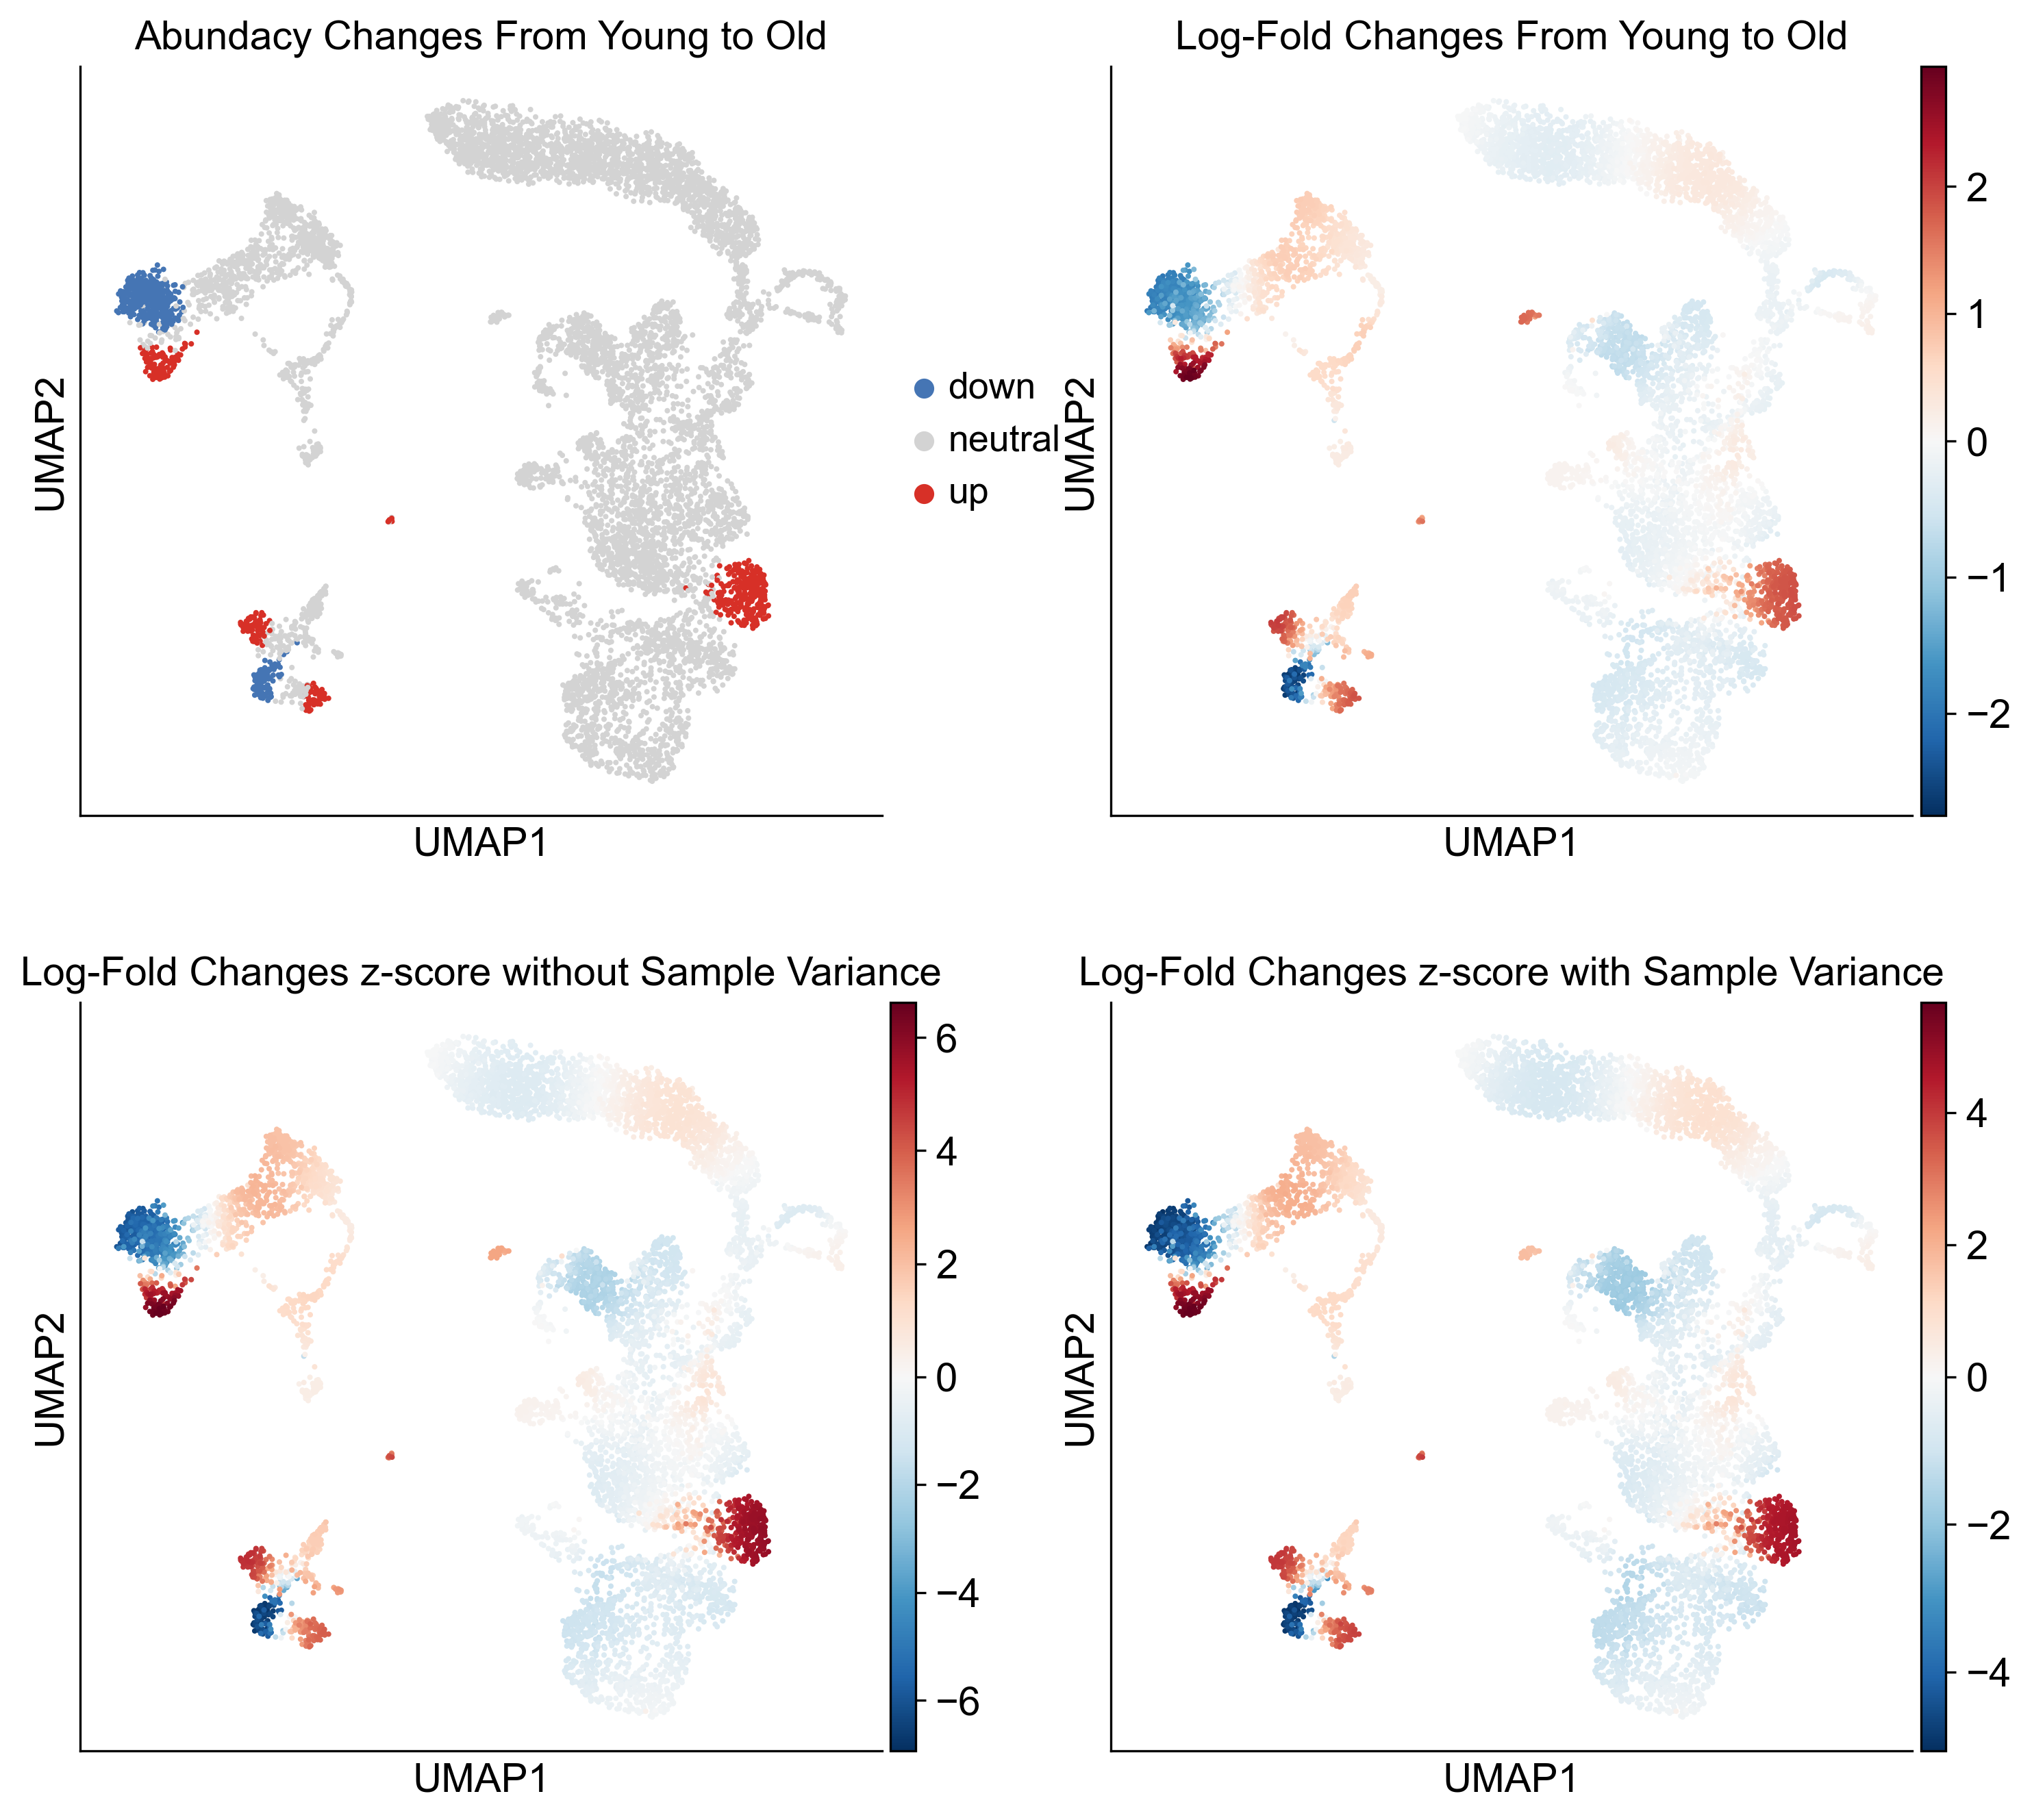

In [11]:
sc.pl.embedding(
    adata,
    "umap",
    color=[
        "kompot_da_log_fold_change_direction_Young_vs_Old",
        "kompot_da_log_fold_change_Young_vs_Old",
        "kompot_da_log_fold_change_zscore_Young_vs_Old",
        "kompot_da_log_fold_change_zscore_Young_vs_Old_sample_var",
    ],
    title=[
        "Abundacy Changes From Young to Old",
        "Log-Fold Changes From Young to Old",
        "Log-Fold Changes z-score without Sample Variance",
        "Log-Fold Changes z-score with Sample Variance",
    ],
    color_map="RdBu_r",
    vcenter=0,
    ncols=2,
)

### Volcano Plots for Differential Abundance

Volcano plots provide another way to visualize differential abundance results. They show the log fold change (effect size) on the x-axis and statistical significance on the y-axis. Points above the horizontal line and outside the vertical lines indicate statistically significant changes.

Let's first look at the standard analysis without sample variance. To specify the ploting function which data to use, we can either provide the `lfc_key` and `pval_key` columns with results written by the `compute_differential_abundance` function, or provide the `run_id` that specifies the differential abundance run based on the order they were executed. The first run has `rund_id=0`:

[2025-03-12 14:37:15,819] [INFO    ] Using DA run 0: comparing Young vs Old
[2025-03-12 14:37:15,819] [INFO    ] Using fields for DA plot - lfc_key: 'kompot_da_log_fold_change_Young_vs_Old', pval_key: 'kompot_da_neg_log10_fold_change_pvalue_Young_vs_Old'
[2025-03-12 14:37:15,820] [INFO    ] Using thresholds - lfc_threshold: 1.0, pval_threshold: 0.05


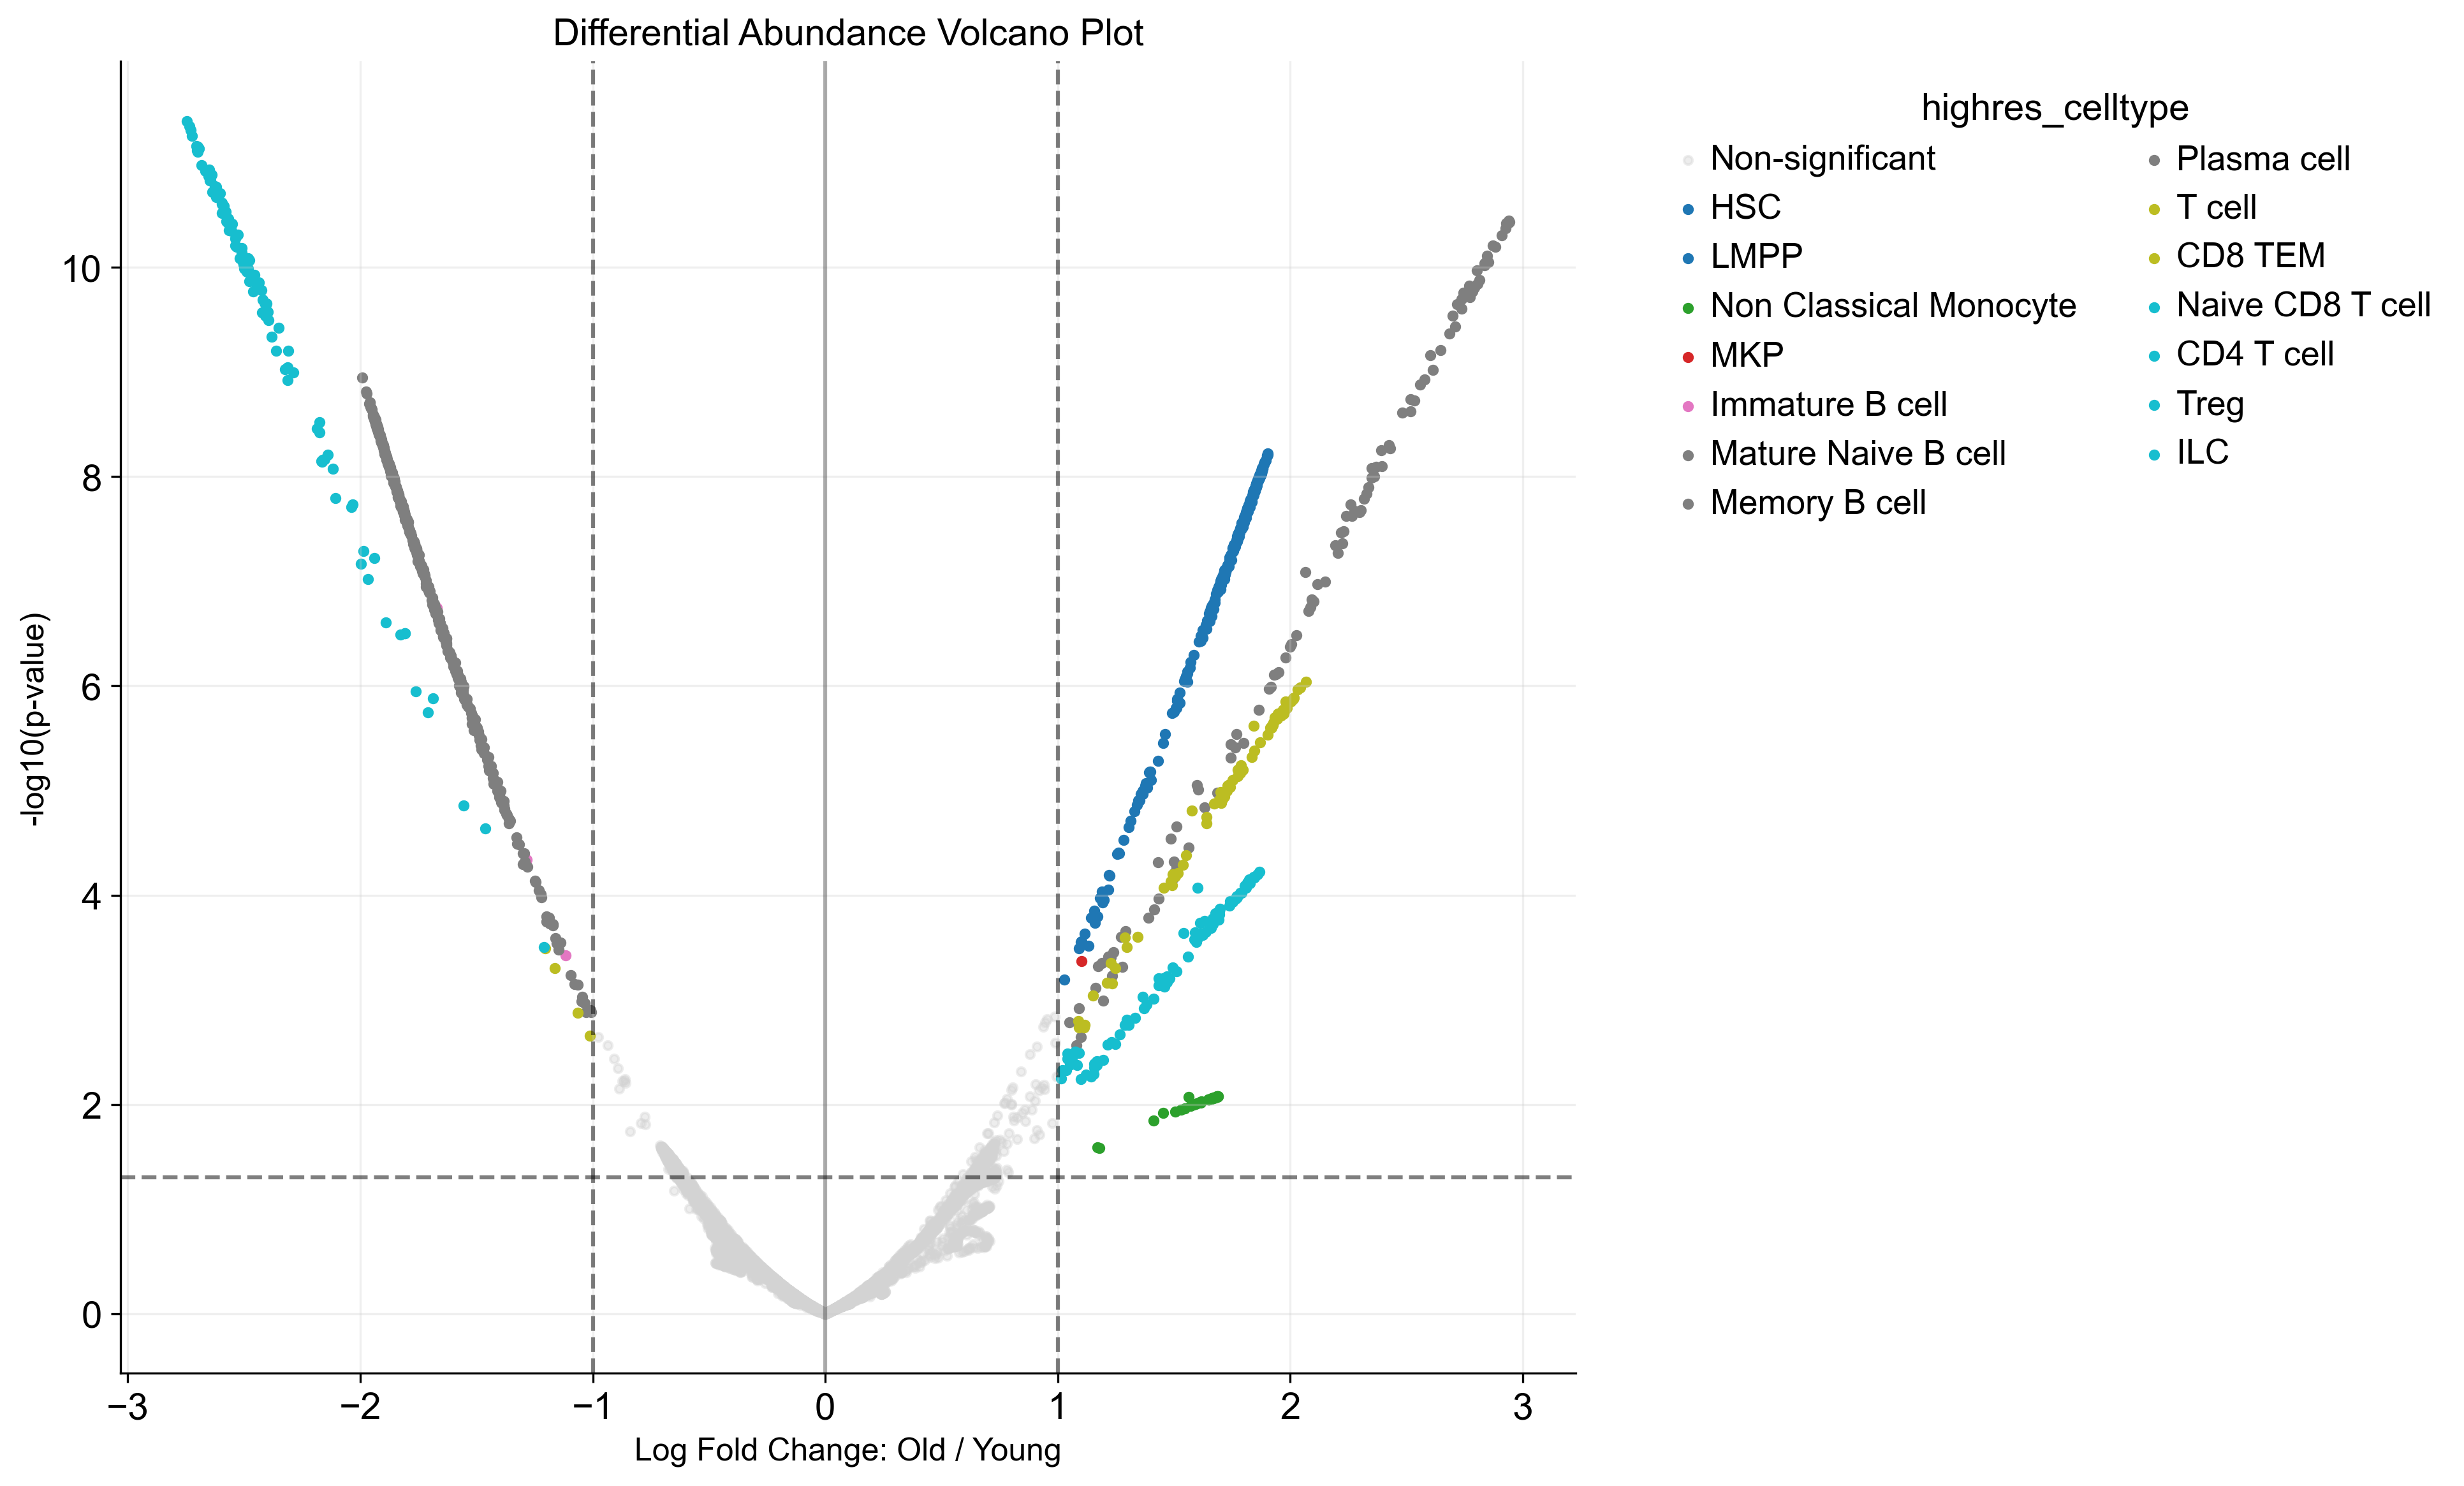

In [20]:
kompot.plot.volcano_da(adata, color=CELL_TYPE_COLUMN, run_id=0)

Now, let's look at the analysis with sample variance (`run_id=1`):

[2025-03-12 14:37:21,386] [INFO    ] Using DA run 1: comparing Young vs Old
[2025-03-12 14:37:21,387] [INFO    ] Using fields for DA plot - lfc_key: 'kompot_da_log_fold_change_Young_vs_Old', pval_key: 'kompot_da_neg_log10_fold_change_pvalue_Young_vs_Old_sample_var'
[2025-03-12 14:37:21,387] [INFO    ] Using thresholds - lfc_threshold: 1.0, pval_threshold: 0.05


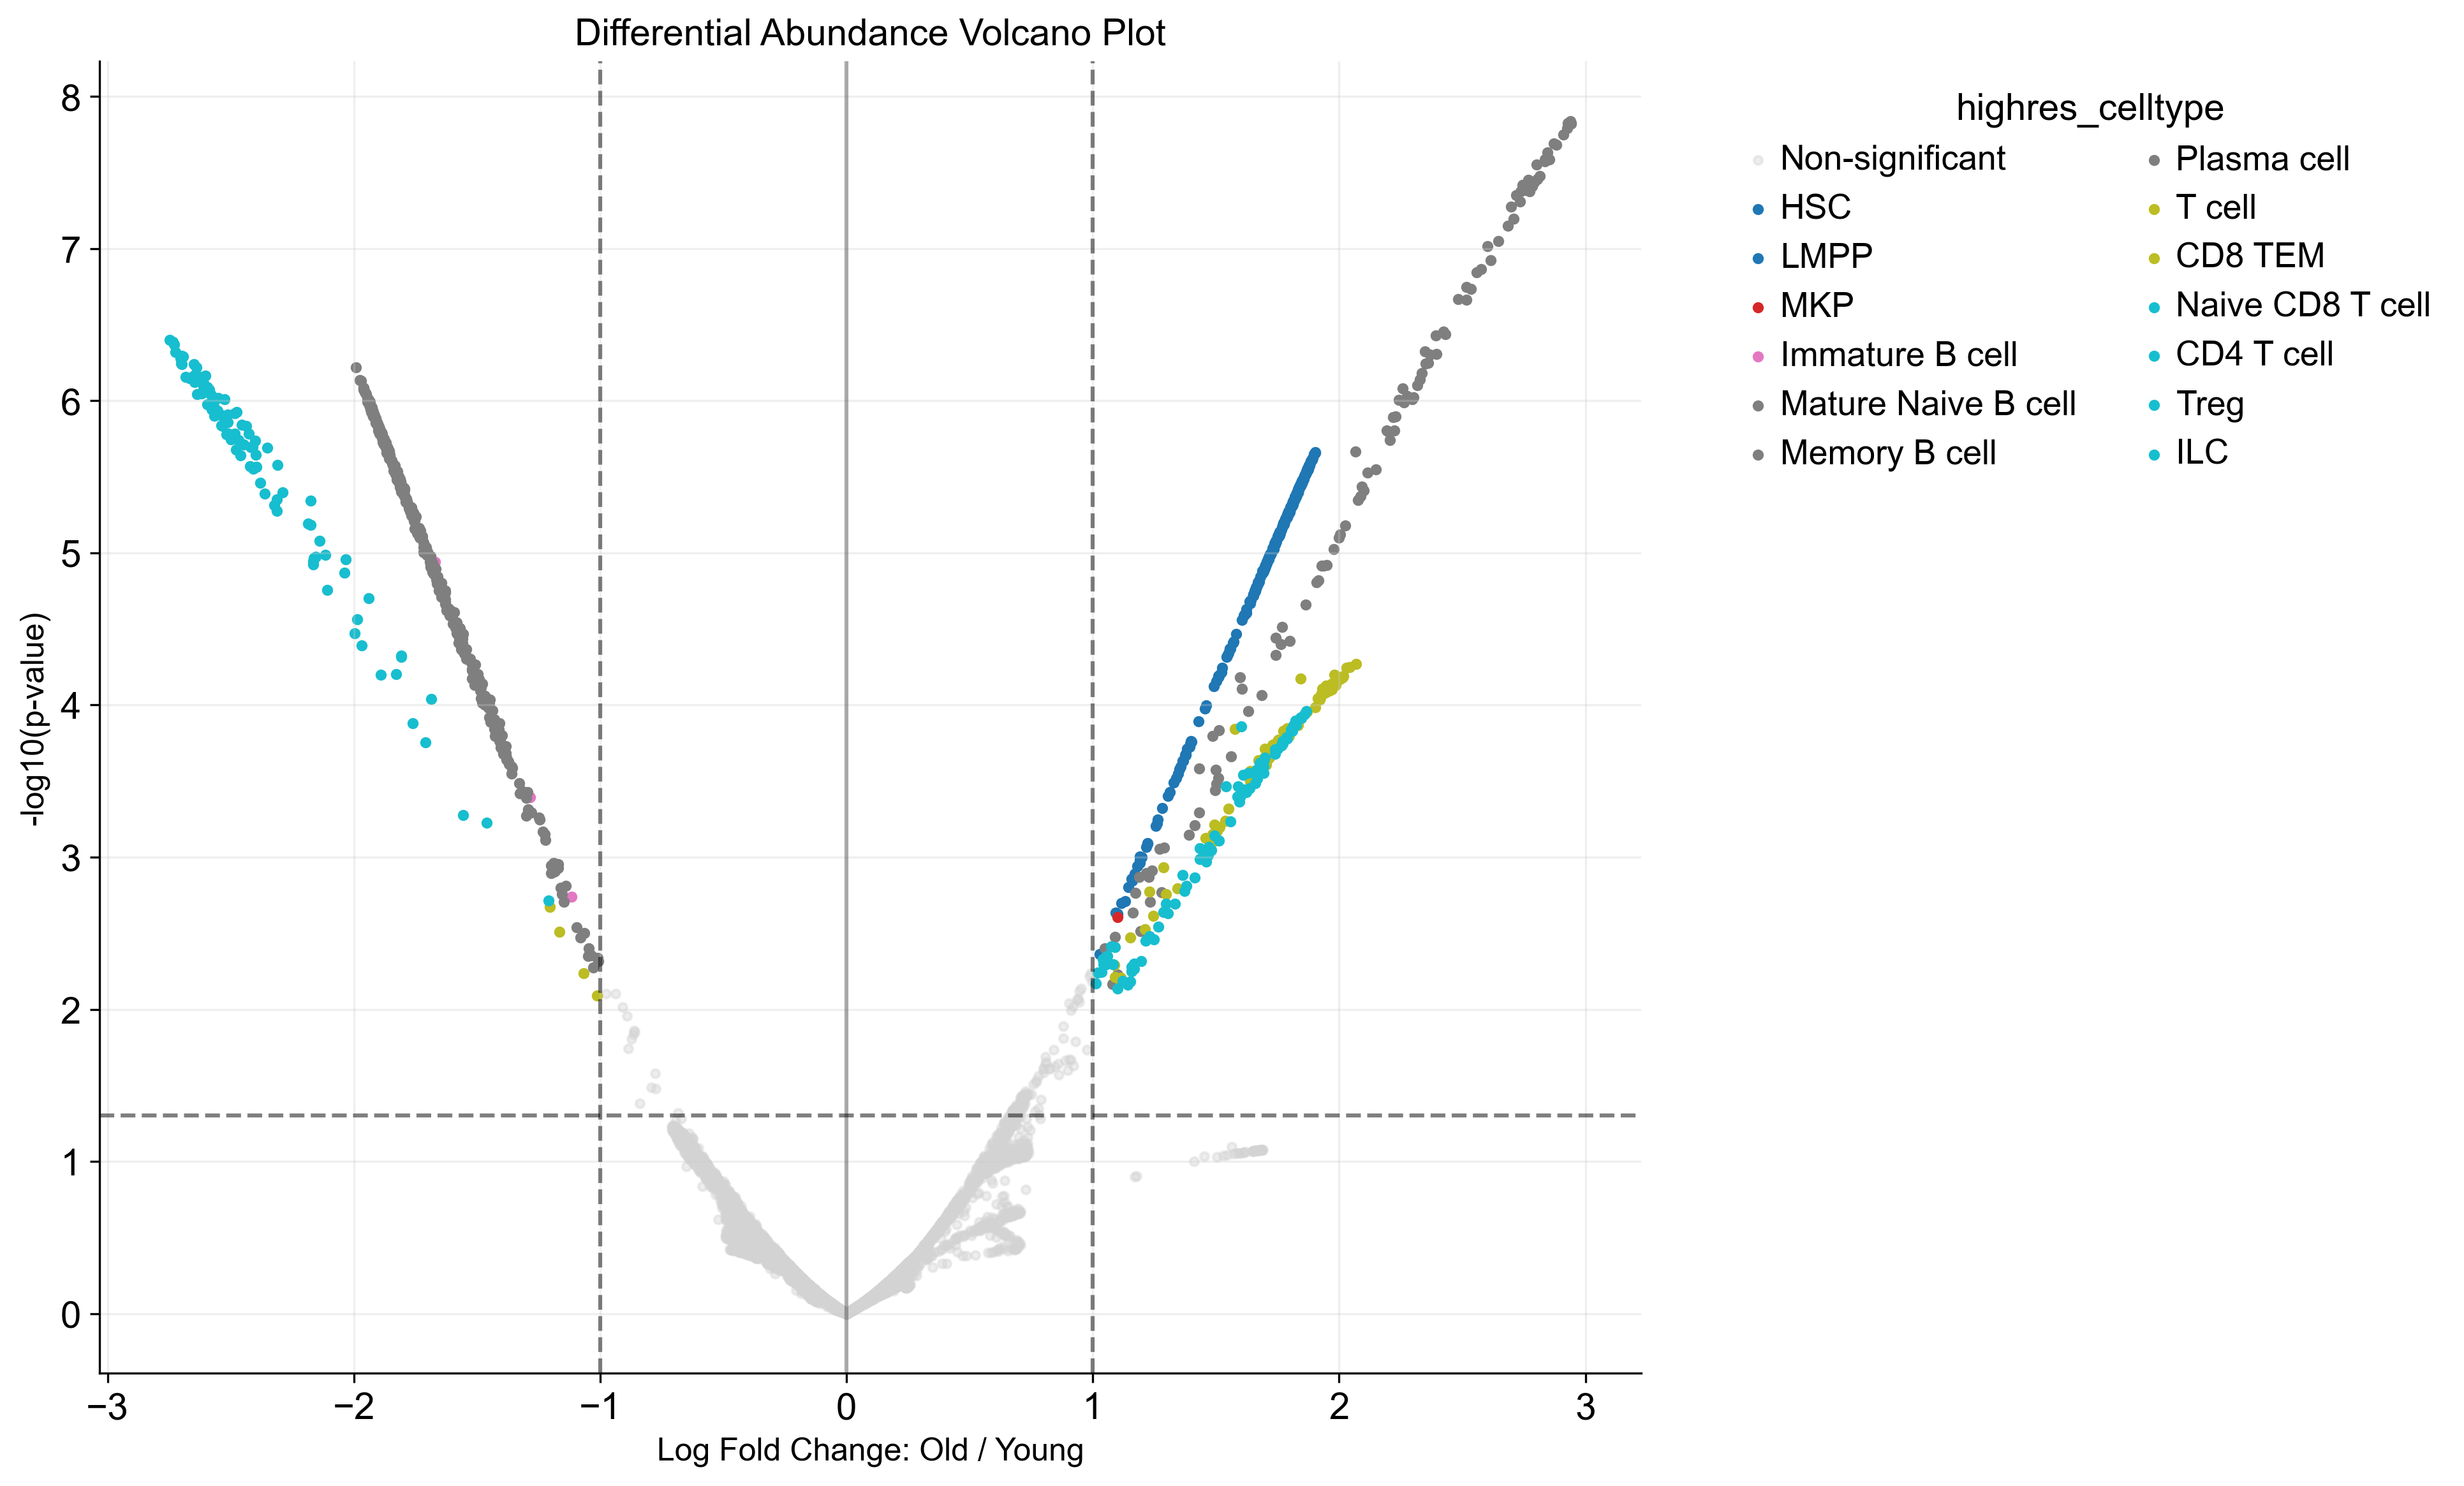

In [21]:
kompot.plot.volcano_da(adata, color=CELL_TYPE_COLUMN, run_id=1)

### Key Observations from Differential Abundance Analysis

Comparing the volcano plots with and without sample variance:

1. **Statistical significance thresholds**: P-values (y-axis) are generally lower when using sample variance, reflecting a more conservative statistical assessment.

2. **Cell type patterns**: Both plots show similar cell type-specific patterns of differential abundance, but the significance estimates differ.

3. **Effect sizes**: Log fold changes (x-axis) remain consistent between methods, as sample variance affects significance but not effect size estimation.

## Comparing Differential Expression Results

Now let's examine how sample variance affects differential gene expression analysis.

### Top Differentially Expressed Genes

First, let's examine the top differentially expressed genes identified in our standard analysis (without sample variance):

In [22]:
adata.var[
    ["kompot_de_weighted_lfc_Young_vs_Old", "kompot_de_mahalanobis_Young_vs_Old"]
].sort_values("kompot_de_mahalanobis_Young_vs_Old", ascending=False).head(20)

kompot_de_weighted_lfc_Young_vs_Old  \
H2-Q7                                1.344973   
Cd74                                 0.525005   
H2-Aa                                0.608966   
H2-Ab1                               0.581043   
Igkc                                 0.079981   
H2-Eb1                               0.541995   
AW112010                             0.916825   
S100a9                              -0.464248   
Ifitm3                               0.580449   
S100a8                              -0.461644   
H2-Q6                                0.862108   
Cd52                                -0.410056   
Aldh1a1                              0.599299   
Ifitm1                               0.656616   
Ifitm2                               0.403111   
Ighm                                -0.292361   
Cd79a                                0.024962   
Apoe                                 0.221597   
Fos                                  0.621791   
Gm47283                              0.647201   

          kompot_de_mahalanobis_Young_vs_Old  
H2-Q7                              71.513350  
Cd74                               60.009649  
H2-Aa                              59.363446  
H2-Ab1                             57.802728  
Igkc                               53.590104  
H2-Eb1                             53.395853  
AW112010                           53.380622  
S100a9                             48.752286  
Ifitm3                             47.574401  
S100a8                             47.359853  
H2-Q6                              45.990023  
Cd52                               45.298494  
Aldh1a1                            44.595483  
Ifitm1                             44.309708  
Ifitm2                             43.930045  
Ighm                               43.203827  
Cd79a                              43.093205  
Apoe                               42.927761  
Fos                                42.283972  
Gm47283                            41.956978

### Volcano Plots for Differential Expression

Now, let's look at volcano plots for differential expression, first without sample variance (`run_id=0`):

[2025-03-12 15:06:51,791] [INFO    ] Using DE run 0: comparing Young vs Old
[2025-03-12 15:06:51,794] [INFO    ] Using fields for DE plot - lfc_key: 'kompot_de_mean_lfc_Young_vs_Old', score_key: 'kompot_de_mahalanobis_Young_vs_Old'


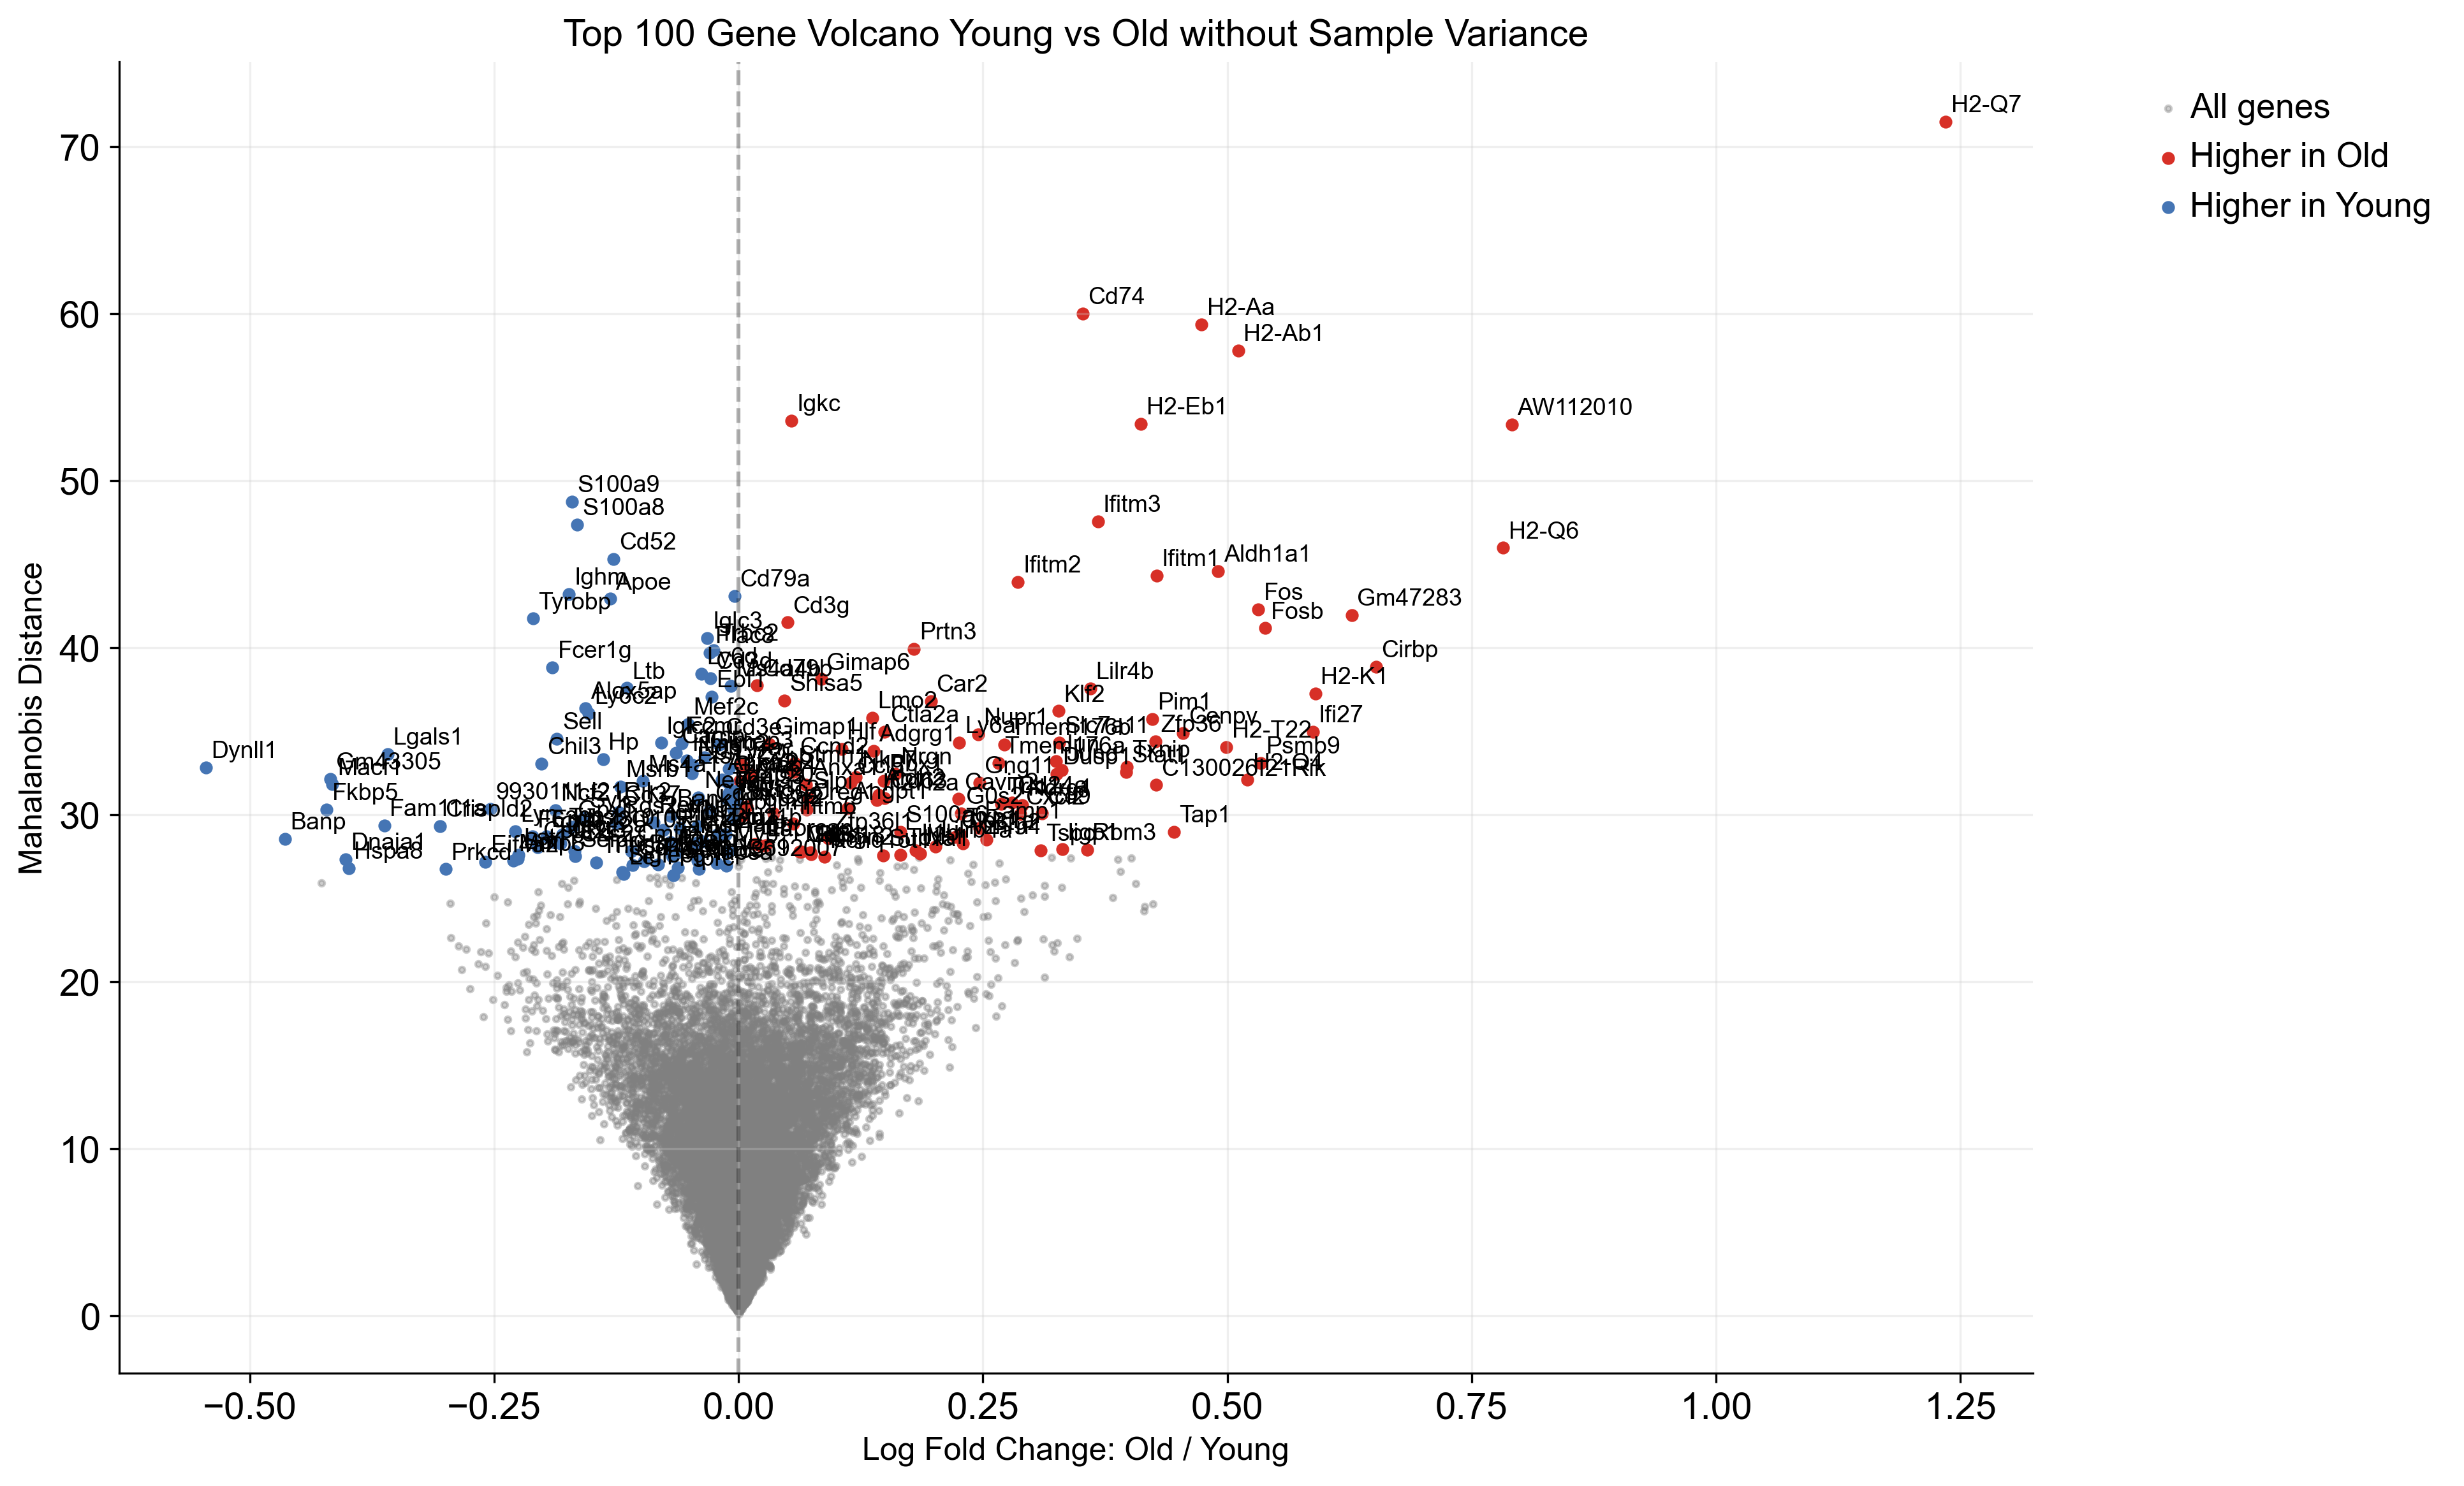

In [9]:
kompot.plot.volcano_de(
    adata,
    n_top_genes=100,
    run_id=0,
    title=f"Top {topn} Gene Volcano Young vs Old without Sample Variance",
)

And now with sample variance (remember we limited this analysis to only the top 100 genes). Note that some genes assert much lower significance (Mahalanobis distance) when accounting for sample variance:

[2025-03-12 14:43:59,998] [INFO    ] Using DE run 1: comparing Young vs Old
[2025-03-12 14:43:59,999] [INFO    ] Using fields for DE plot - lfc_key: 'kompot_de_mean_lfc_Young_vs_Old', score_key: 'kompot_de_mahalanobis_Young_vs_Old_sample_var'


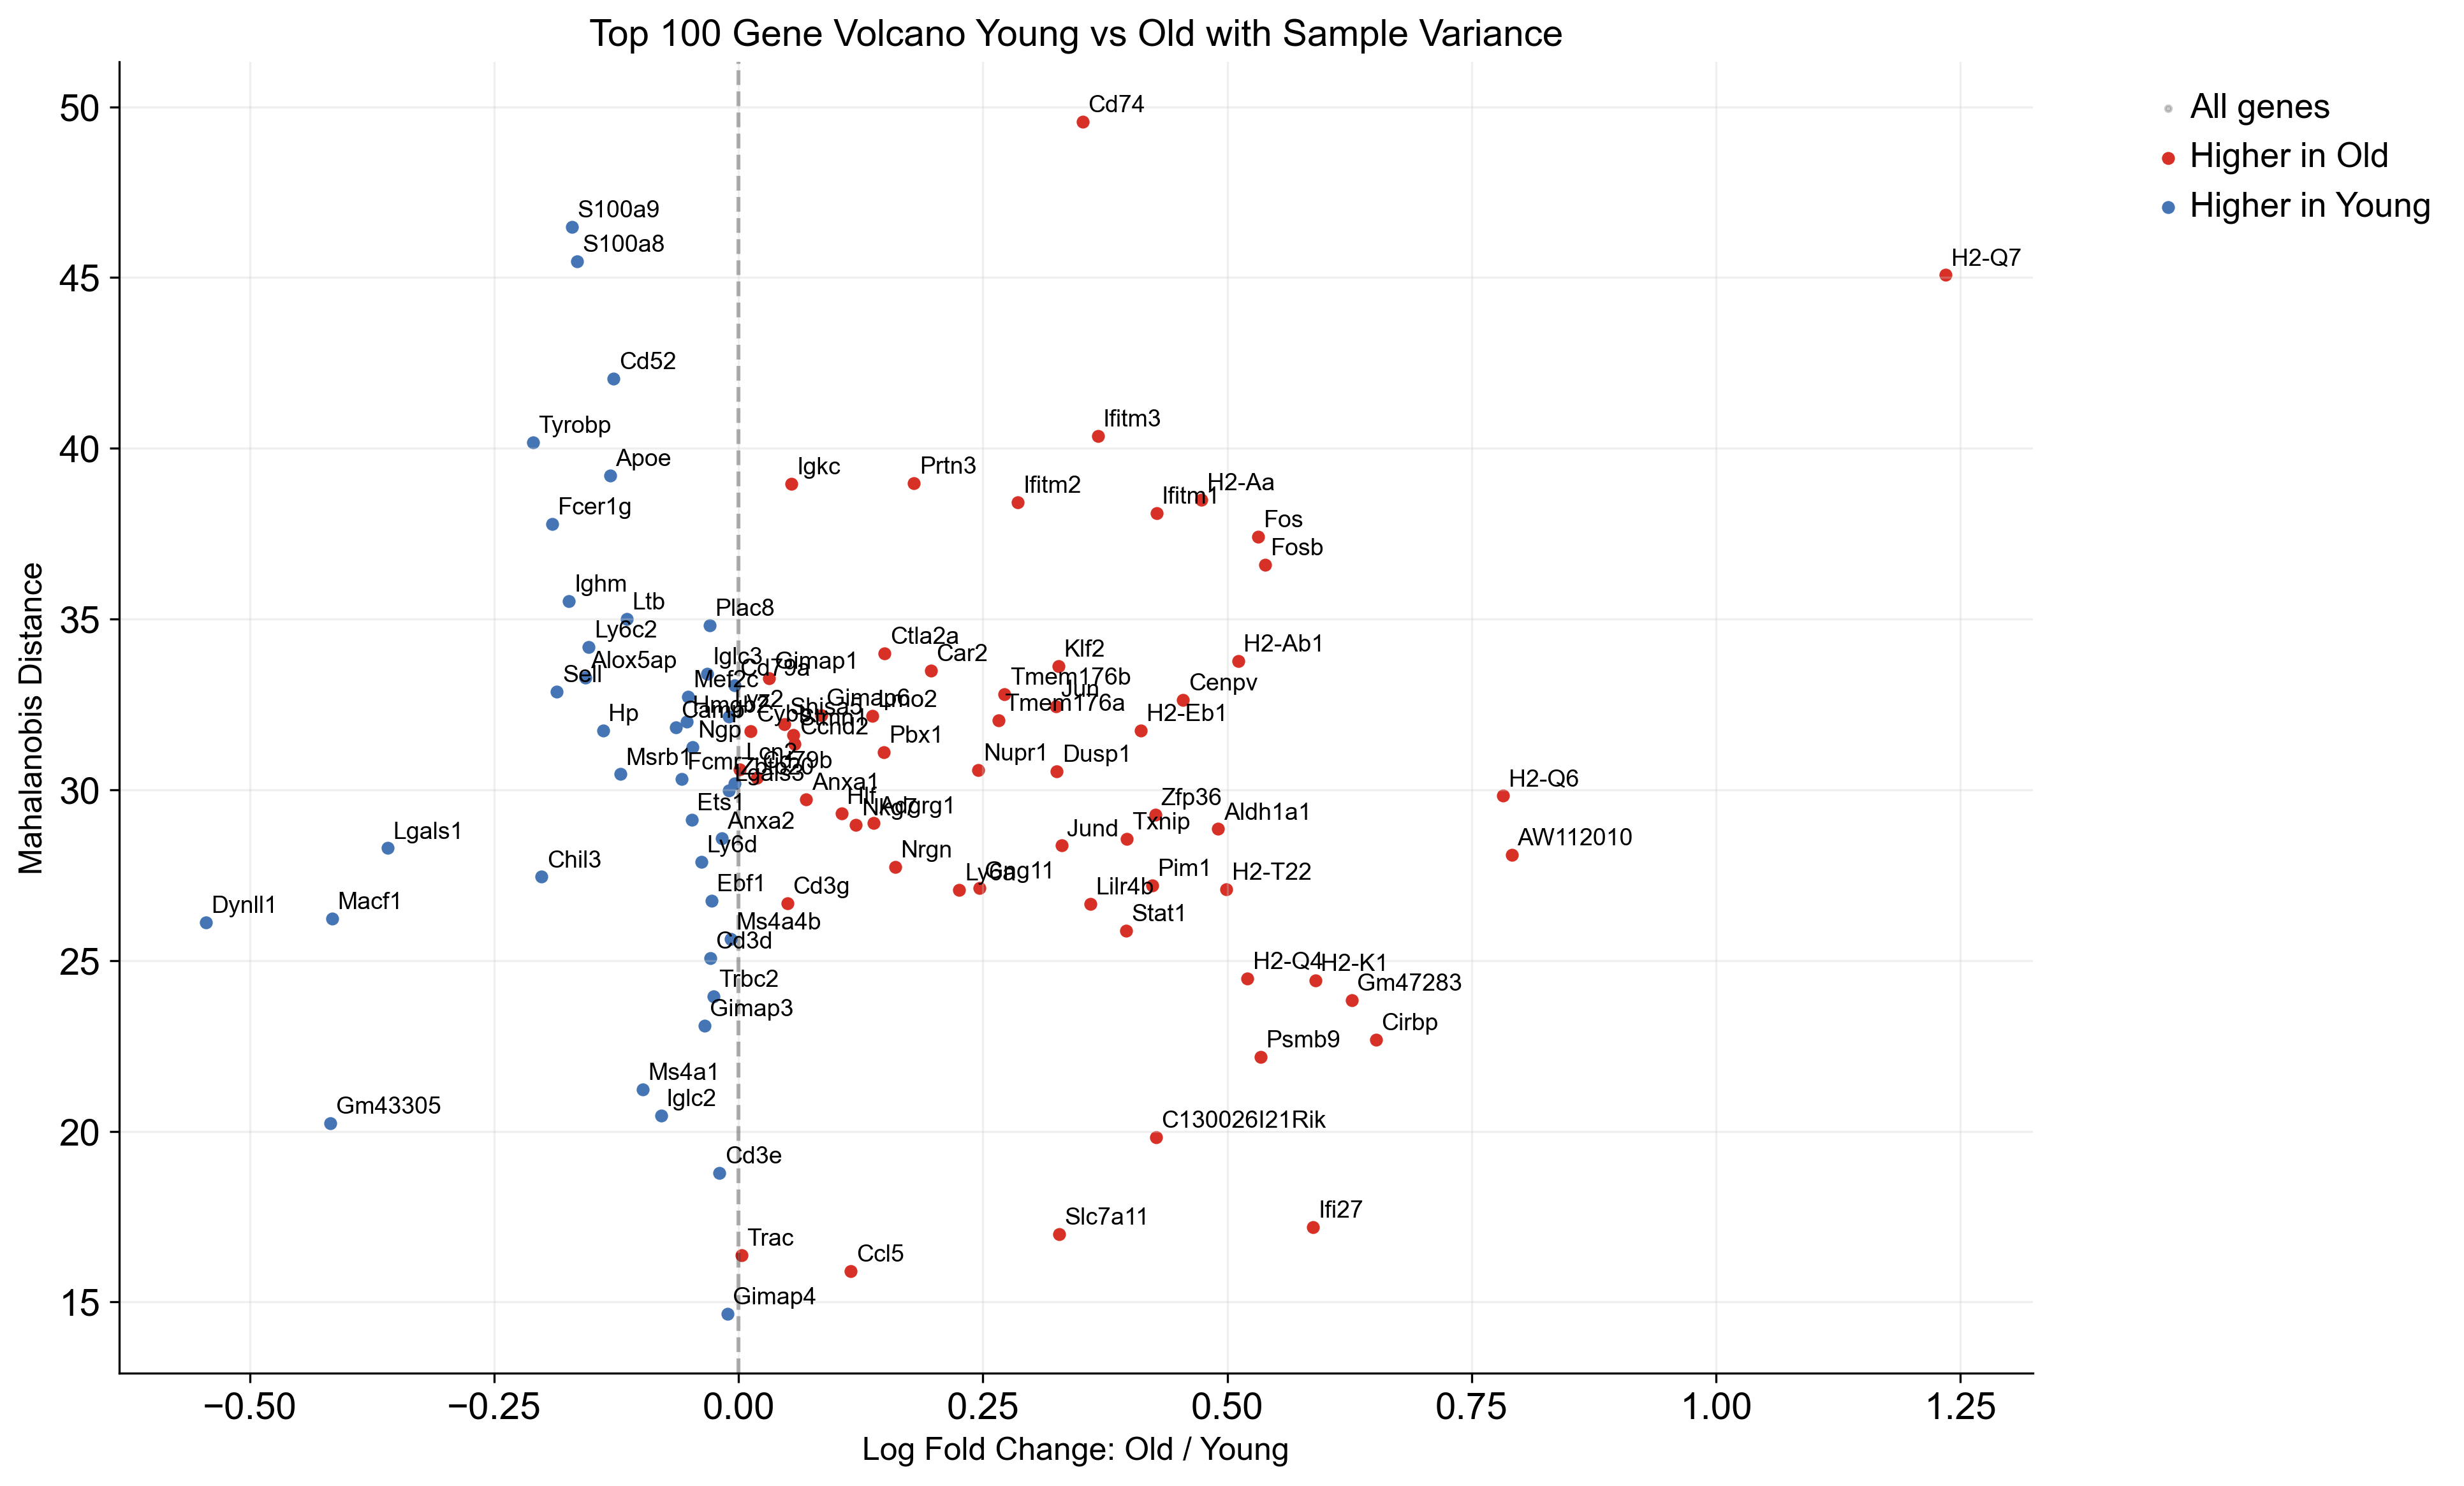

In [27]:
kompot.plot.volcano_de(
    adata,
    n_top_genes=100,
    run_id=1,
    title=f"Top {topn} Gene Volcano Young vs Old with Sample Variance",
)

### Heatmaps of Top Differentially Expressed Genes

Heatmaps provide a cell type-specific view of expression changes. These expression changes are just averages of the actual expression values per group and not a result of kompot. However, the gene ranking is done through the Mahalnobis distance computed by Kompot. Let's create heatmaps for the top genes identified with and without sample variance.

First, from the ranking without considering sample variance (`run_id=0`):

[2025-03-13 00:50:18,017] [INFO    ] Using DE run 0 for heatmap.
[2025-03-13 00:50:18,017] [INFO    ] Inferred score_key='kompot_de_mahalanobis_Young_vs_Old' from run information
[2025-03-13 00:50:18,020] [INFO    ] Inferred condition_column='Age' from run information
[2025-03-13 00:50:18,020] [INFO    ] Inferred condition1='Young' from run information
[2025-03-13 00:50:18,020] [INFO    ] Inferred condition2='Old' from run information
[2025-03-13 00:50:18,020] [INFO    ] Inferred layer='logged_counts' from run information
[2025-03-13 00:50:18,021] [INFO    ] Creating split heatmap with 20 genes/features
[2025-03-13 00:50:18,021] [INFO    ] Using expression data from layer: 'logged_counts'
[2025-03-13 00:50:18,048] [INFO    ] Excluded 7 cells from groups: Plasma cell
[2025-03-13 00:50:18,052] [INFO    ] Applying gene-wise z-scoring (standard_scale='var')


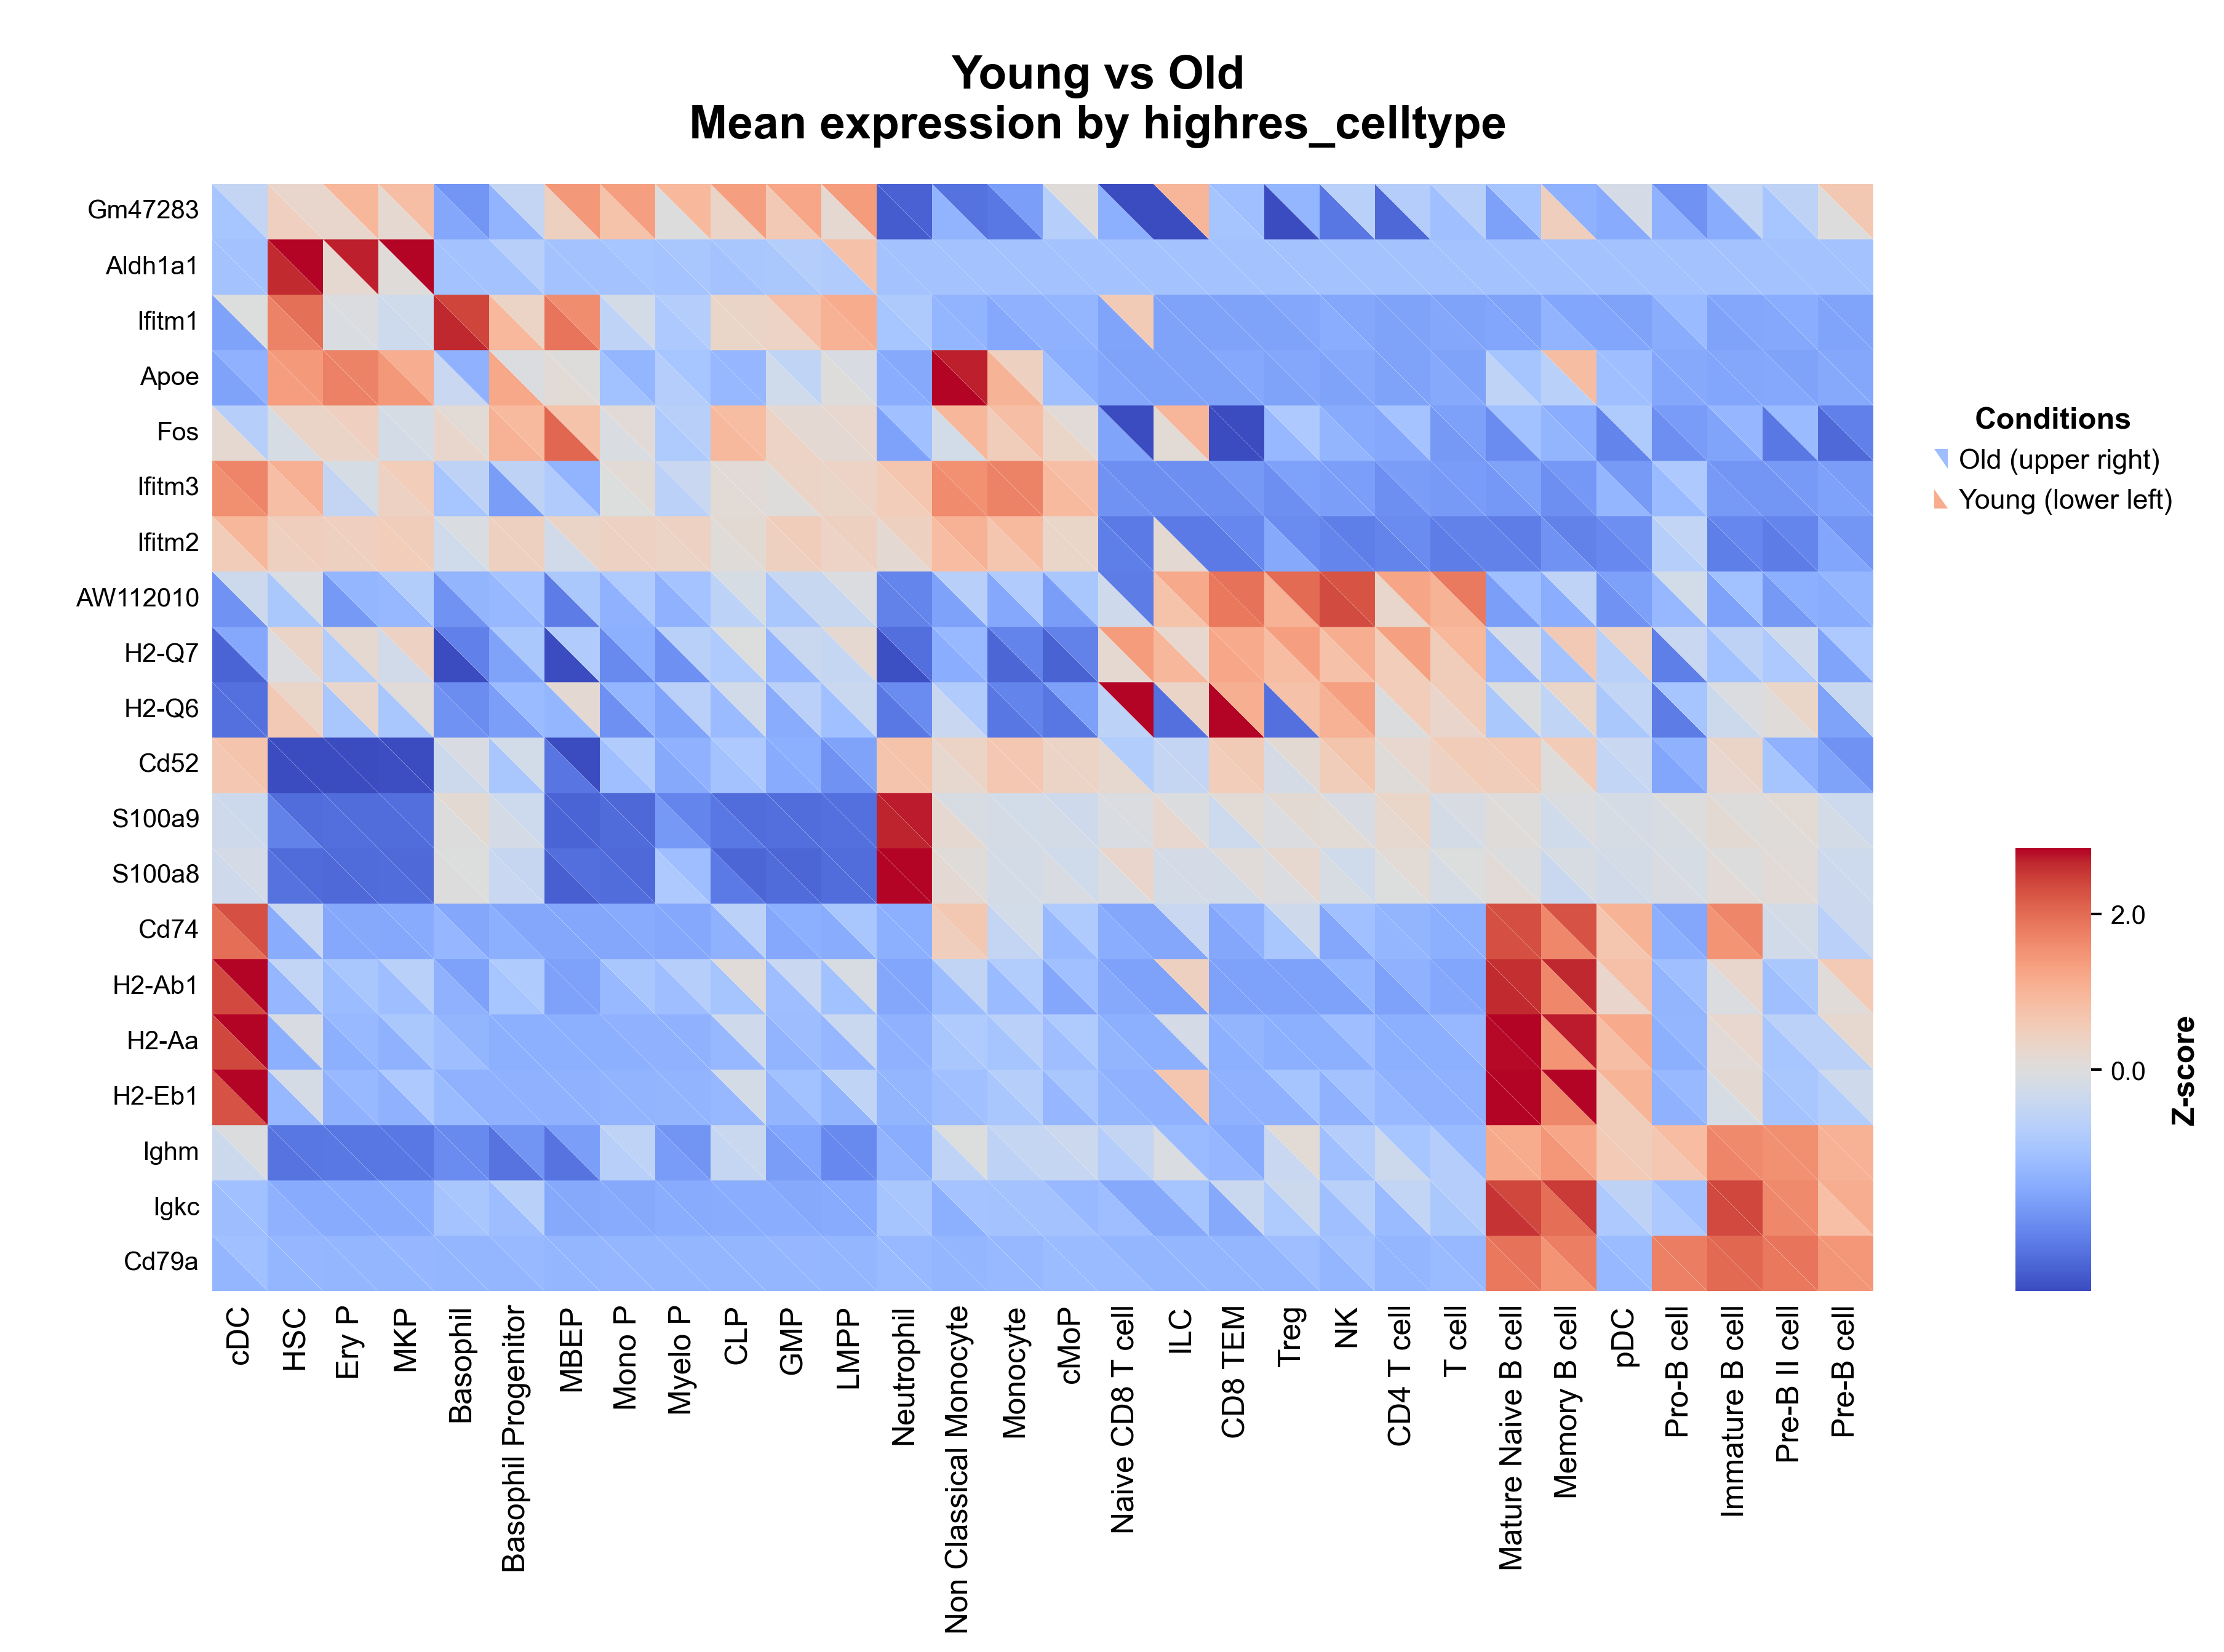

In [99]:
kompot.plot.heatmap(
    adata,
    n_top_genes=20,
    groupby=CELL_TYPE_COLUMN,
    exclude_groups="Plasma cell",
    run_id=0,
    vmin="p1",
    vmax="p99",
)

Now, showing the top 20 genes when ranking them considering sample variance (`run_id=1`):

Inspecting the worst performing genes by scoring under consideration of sample variance, we see considerable variability across the replicates, here comparing replicate 1 and 3:

[2025-03-13 00:50:39,626] [INFO    ] Inferred layer='logged_counts' from run information
[2025-03-13 00:50:39,626] [INFO    ] Creating split heatmap with 20 genes/features
[2025-03-13 00:50:39,626] [INFO    ] Using display names: 'Replicate 1' for condition1, 'Replicate 3' for condition2
[2025-03-13 00:50:39,627] [INFO    ] Using expression data from layer: 'logged_counts'
[2025-03-13 00:50:39,659] [INFO    ] Applying gene-wise z-scoring (standard_scale='var')


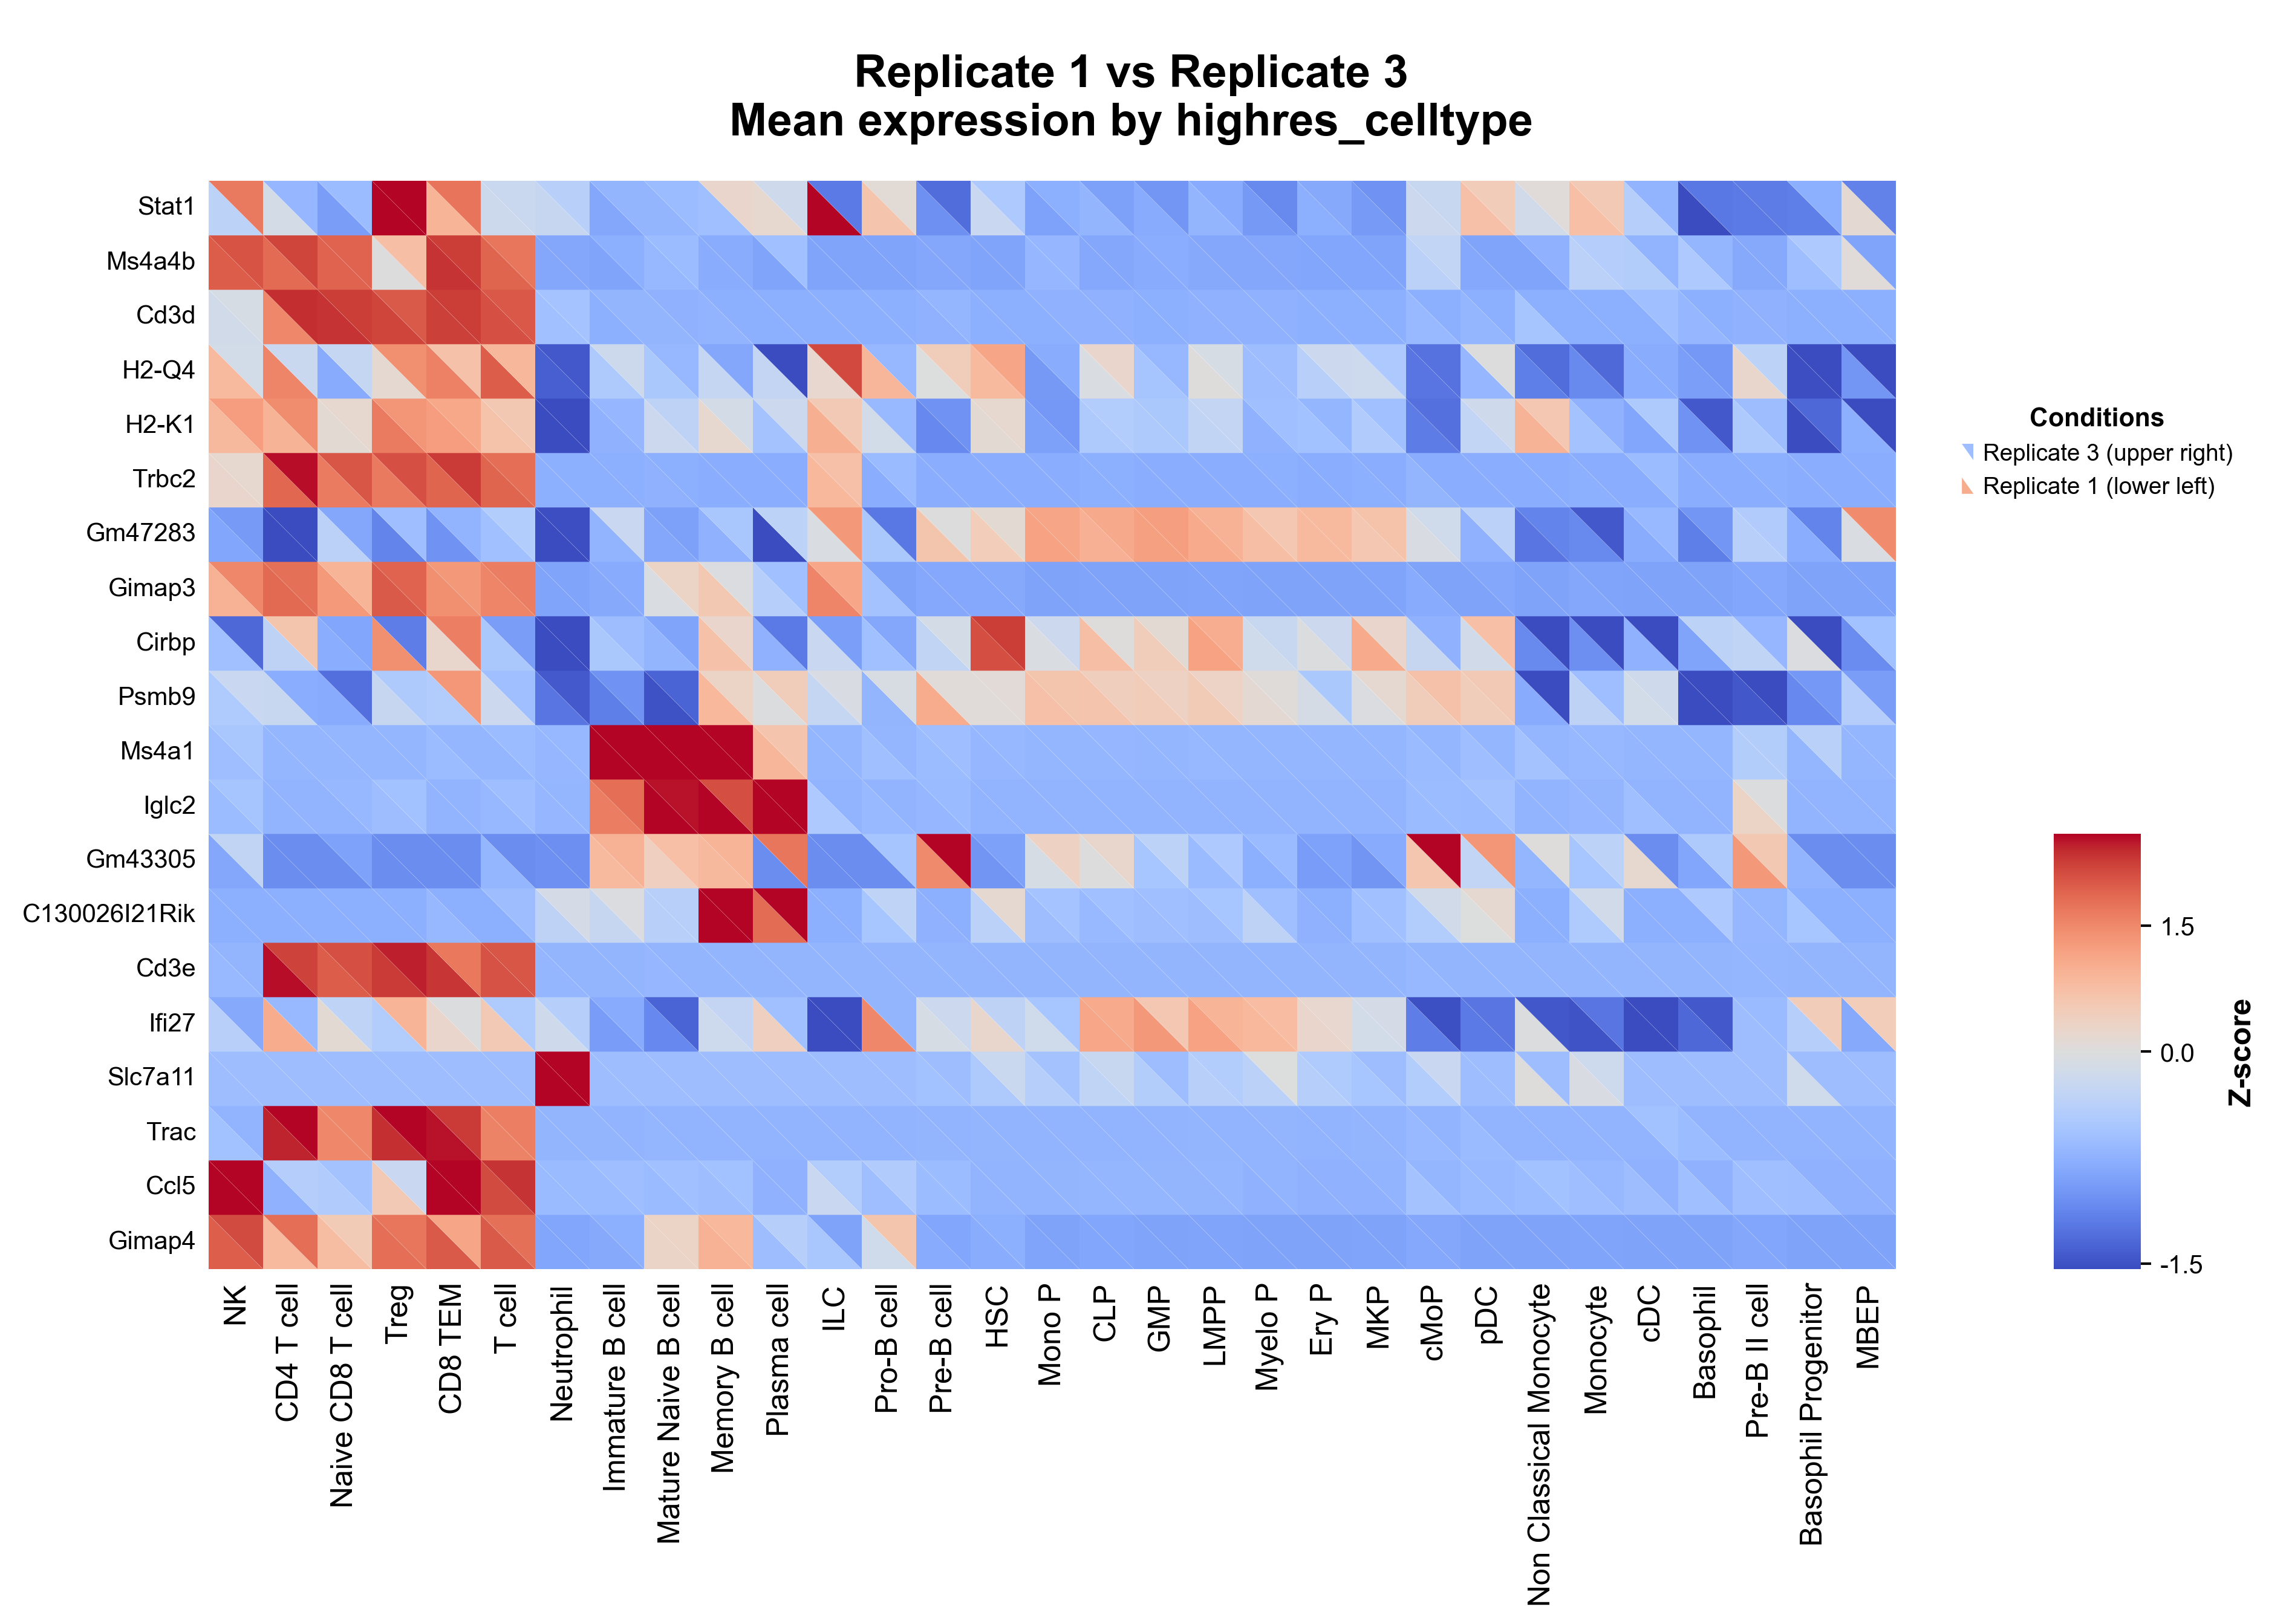

In [100]:
kompot.plot.heatmap(
    adata,
    genes=adata.var.sort_values(
        "kompot_de_mahalanobis_Young_vs_Old_sample_var", ascending=False, na_position='first'
    ).tail(20).index,
    groupby=CELL_TYPE_COLUMN,
    condition_column=SAMPLE_COLUMN,
    condition1="1",
    condition1_name="Replicate 1",
    condition2="3",
    condition2_name="Replicate 3",
    vmin="p2",
    vmax="p98",
    cluster_rows=False,
)

### Detailed Expression Visualization

For specific genes of interest, we can create detailed visualizations that show:
1. Original expression
2. Imputed expression in each condition
3. Log fold change between conditions

Since these results are not effected by sample variance, we can let the plotting function pick the latest result.

Let's look at a T-cell marker gene (Cd3g):

[2025-03-12 14:42:05,802] [INFO    ] Using DE run 1: comparing Young vs Old
[2025-03-12 14:42:05,803] [INFO    ] Using fields for gene expression plot - lfc_key: 'kompot_de_mean_lfc_Young_vs_Old', score_key: 'kompot_de_mahalanobis_Young_vs_Old_sample_var'
[2025-03-12 14:42:05,803] [INFO    ] Using layer 'logged_counts' inferred from run information
[2025-03-12 14:42:05,804] [INFO    ] Using condition1 imputed layer 'kompot_de_imputed_Young' for 'Young'
[2025-03-12 14:42:05,804] [INFO    ] Using condition2 imputed layer 'kompot_de_imputed_Old' for 'Old'
[2025-03-12 14:42:05,805] [INFO    ] Using fold_change layer 'kompot_de_fold_change_Young_vs_Old' from run_info


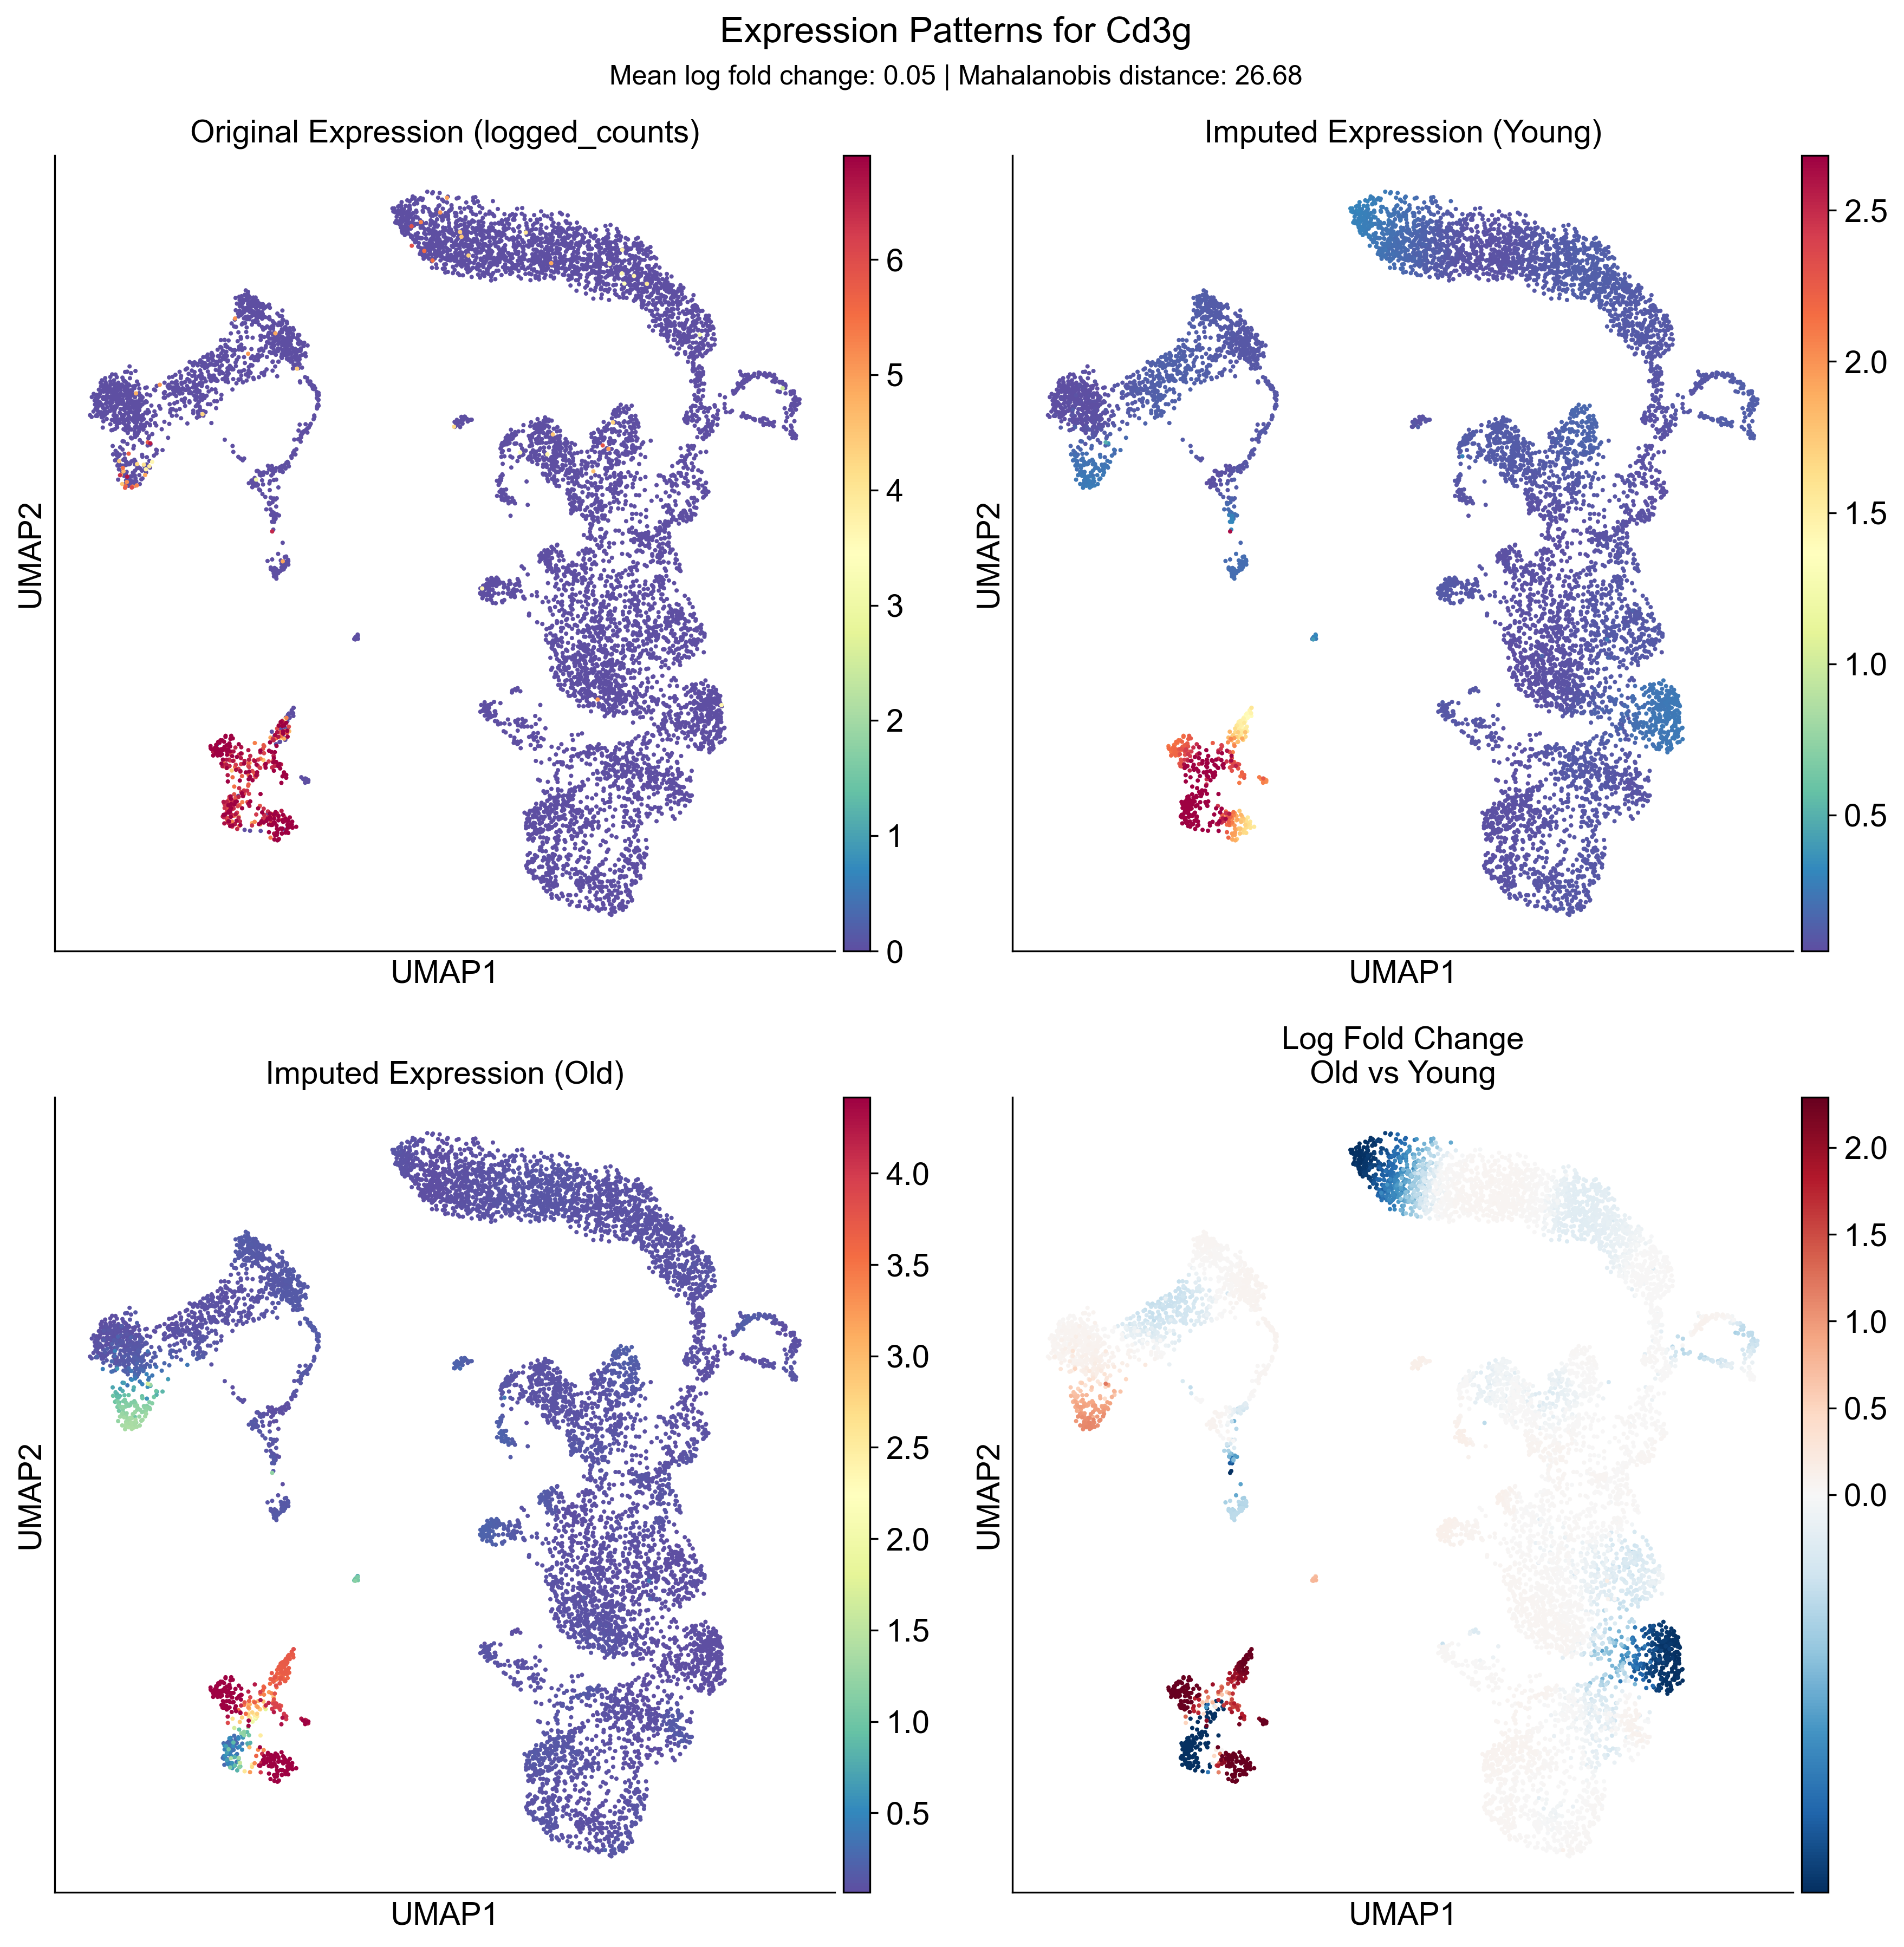

In [26]:
kompot.plot.plot_gene_expression(adata, gene="Cd3g", vmin="p2", vmax="p98")

## Conclusion: Impact of Sample Variance

After comparing both approaches, several key insights emerge:

1. **Reduced false positives**: Sample variance correction typically reduces the number of statistically significant findings, particularly for genes with high variability between samples.

2. **More robust biomarkers**: Genes that remain significant after sample variance correction are more likely to represent robust biological differences between conditions rather than sample-specific effects.

3. **Unchanged effect sizes**: Note that the log fold changes themselves remain similar with both methods; it's the statistical significance (p-values) that changes.

4. **Cell type specificity**: Some cell types show more consistent changes across samples than others, which becomes apparent when using sample variance correction.

For experiments with multiple biological replicates per condition, we strongly recommend using the sample variance correction approach to avoid inflated significance estimates and to identify the most robust biological signals.